# price回归模型

In [1]:
"""这个模型数据处理的代码写得非常地冗余，因为一开始没有什么思路，所以先处理了一个文件，
并且几乎每列数据都单独处理，最终导致了这样的代码屎山。另一个模型的数据处理较为精简"""

'这个模型数据处理的代码写得非常地冗余，因为一开始没有什么思路，所以先处理了一个文件，\n并且几乎每列数据都单独处理，最终导致了这样的代码屎山。另一个模型的数据处理较为精简'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import re
import random
import seaborn as sns
from scipy.stats.mstats import winsorize

In [3]:
# 加载数据
train_price = pd.read_csv('ruc_Class25Q2_train_price.csv', low_memory=False)  # 销售训练集 防止 Pandas 分块读取大型 CSV 导致数据类型推断不准确
test_price = pd.read_csv('ruc_Class25Q2_test_price.csv', low_memory=False)    # 销售测试集

In [4]:
# 查看销售训练集的形状和列名
print("销售训练集形状：", train_price.shape)  # 行数和列数
print("\n销售训练集的列名：")
print(train_price.columns.tolist())  # 所有列名列表

print(test_price.columns.tolist())

销售训练集形状： (103871, 55)

销售训练集的列名：
['城市', '区域', '板块', '环线', 'Price', '房屋户型', '所在楼层', '建筑面积', '套内面积', '房屋朝向', '建筑结构', '装修情况', '梯户比例', '配备电梯', '别墅类型', '交易时间', '交易权属', '上次交易', '房屋用途', '房屋年限', '产权所属', '抵押信息', '房屋优势', '核心卖点', '户型介绍', '周边配套', '交通出行', 'lon', 'lat', '年份', '区县', '板块_comm', '环线位置', '物业类别', '建筑年代', '开发商', '房屋总数', '楼栋总数', '物业公司', '绿 化 率', '容 积 率', '物 业 费', '建筑结构_comm', '物业办公电话', '产权描述', '供水', '供暖', '供电', '燃气费', '供热费', '停车位', '停车费用', 'coord_x', 'coord_y', '客户反馈']
['ID', '城市', '区域', '板块', '环线', '房屋户型', '所在楼层', '建筑面积', '套内面积', '房屋朝向', '建筑结构', '装修情况', '梯户比例', '配备电梯', '别墅类型', '交易时间', '交易权属', '上次交易', '房屋用途', '房屋年限', '产权所属', '抵押信息', '房屋优势', '核心卖点', '户型介绍', '周边配套', '交通出行', 'lon', 'lat', '年份', '区县', '板块_comm', '环线位置', '物业类别', '建筑年代', '开发商', '房屋总数', '楼栋总数', '物业公司', '绿 化 率', '容 积 率', '物 业 费', '建筑结构_comm', '物业办公电话', '产权描述', '供水', '供暖', '供电', '燃气费', '供热费', '停车位', '停车费用', 'coord_x', 'coord_y', '客户反馈']


## step1 数据处理

### 训练集数据处理

In [5]:
# 检查“抵押信息”是否全为空白值
is_blank = train_price['抵押信息'].isna() | (train_price['抵押信息'].fillna('') == '')
total_blank = is_blank.sum()
total_rows = len(train_price)
    
if total_blank == total_rows:
    print("'抵押信息'列全为空白值")
else:
    print(f"'抵押信息'列非空白值共{total_rows - total_blank}个（非空白比例：{(total_rows - total_blank)/total_rows:.2%}）")

# 删除冗余列和临时编码列
train_price = train_price.drop(columns=['抵押信息'])  # 删除冗余列

# 输出处理后的结果
print("\n处理后销售训练集形状：", train_price.shape)
print("处理后销售训练集列名：")
print(train_price.columns.tolist())

'抵押信息'列全为空白值

处理后销售训练集形状： (103871, 54)
处理后销售训练集列名：
['城市', '区域', '板块', '环线', 'Price', '房屋户型', '所在楼层', '建筑面积', '套内面积', '房屋朝向', '建筑结构', '装修情况', '梯户比例', '配备电梯', '别墅类型', '交易时间', '交易权属', '上次交易', '房屋用途', '房屋年限', '产权所属', '房屋优势', '核心卖点', '户型介绍', '周边配套', '交通出行', 'lon', 'lat', '年份', '区县', '板块_comm', '环线位置', '物业类别', '建筑年代', '开发商', '房屋总数', '楼栋总数', '物业公司', '绿 化 率', '容 积 率', '物 业 费', '建筑结构_comm', '物业办公电话', '产权描述', '供水', '供暖', '供电', '燃气费', '供热费', '停车位', '停车费用', 'coord_x', 'coord_y', '客户反馈']


In [6]:
"""数值转换（针对本来就含有数值的数据列，处理区间值、单位等）"""

# 定义各类特征的转换函数
def convert_area(s):  # 建筑面积、套内面积（提取xx㎡中的数值）
    if pd.isna(s):
        return None
    s = str(s).strip()
    match = re.search(r'(\d+\.?\d*)', s)
    return float(match.group(1)) if match else None


# 梯户比例修改 
def chinese_to_number(s):
    """将中文数字字符串（如“两”“十九”“二十四”）转换为阿拉伯数字"""
    chinese_num = {
        '零': 0, '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9,
        '十': 10, '百': 100, '千': 1000, '万': 10000, '两': 2
    }
    num = 0
    unit = 1  # 记录当前单位（十、百、千等）
    for c in reversed(s):  # 从右向左解析
        if c in chinese_num:
            val = chinese_num[c]
            if val >= 10:  # 遇到“十、百、千”等单位
                unit = val
                if num == 0:  # 处理“十、百”单独出现的情况（如“十”=10）
                    num = 1
            else:  # 遇到“一、二、两...九”
                num += val * unit
        else:
            return None  # 非中文数字返回None
    return num if num != 0 else 0  # 避免空字符串返回0


def convert_ladder_household(s):  # 梯户比例（支持“两梯十九户”等场景）
    if pd.isna(s):
        return None
    s = str(s).strip()
    
    # 匹配“X梯Y户”结构，X和Y为中文数字（支持“两”“十九”等）
    import re
    match = re.match(r'(.+)梯(.+)户', s)
    if not match:
        return None
    
    ladder_chinese = match.group(1).strip()  # 电梯数：“两”
    household_chinese = match.group(2).strip()  # 户数：“十九”
    
    # 转换为阿拉伯数字
    ladder = chinese_to_number(ladder_chinese)  # “两”→2
    household = chinese_to_number(household_chinese)  # “十九”→19
    
    if ladder is not None and household is not None and household != 0:
        return ladder / household  # 2/19≈0.105
    else:
        return None

def convert_house_age(s):  # 房屋年限（文本描述转数值：未满两年→1等）
    mapping = {'未满两年':1, '满两年':2, '满五年':5}
    if pd.isna(s):
        return None
    s = str(s).strip()
    return float(mapping[s]) if s in mapping else None

def convert_build_year(s):  # 建筑年代（提取年份数值）
    if pd.isna(s):
        return None
    s = str(s).strip()
    match = re.findall(r'(\d{4})', s)
    return float(match[0]) if match else None

def convert_house_total(s):  # 房屋总数、楼栋总数（提取户数/楼栋数）
    if pd.isna(s):
        return None
    s = str(s).strip()
    match = re.search(r'(\d+)', s)
    return float(match.group(1)) if match else None

def convert_green_rate(s):  # 绿化率（xx%转小数）
    if pd.isna(s):
        return None
    s = str(s).strip()
    match = re.search(r'(\d+\.?\d*)%', s)
    return float(match.group(1))/100 if match else None

def convert_fee(s):  # 物业费、燃气费等（提取费用数值，范围取平均）
    if pd.isna(s):
        return None
    s = str(s).strip()
    nums = re.findall(r'(\d+\.?\d*)', s)
    if len(nums) == 1:
        return float(nums[0])
    elif len(nums)>=2:
        return (float(nums[0]) + float(nums[1]))/2
    return None

def convert_parking_fee(s):  # 停车费用（提取数值，多值取平均）
    if pd.isna(s):
        return None
    s = str(s).strip()
    nums = re.findall(r'(\d+\.?\d*)', s)
    if nums:
        return sum(float(num) for num in nums)/len(nums)
    return None

# 应用转换函数到指定列
converters = {
    '建筑面积': convert_area,
    '套内面积': convert_area,
    '梯户比例': convert_ladder_household,
    '房屋年限': convert_house_age,
    '建筑年代': convert_build_year,
    '房屋总数': convert_house_total,
    '楼栋总数': convert_house_total,
    '绿 化 率': convert_green_rate,
    '物 业 费': convert_fee,
    '燃气费': convert_fee,
    '供热费': convert_fee,
    '停车费用': convert_parking_fee
}

for col, func in converters.items():
    train_price[col] = train_price[col].apply(func)  # 应用转换
    train_price[col] = train_price[col].astype(float)  # 强制转为float
    missing_count = train_price[col].isna().sum()
    print(f"{col}：已转为float，当前缺失值数量={missing_count}")

建筑面积：已转为float，当前缺失值数量=0
套内面积：已转为float，当前缺失值数量=67887
梯户比例：已转为float，当前缺失值数量=2619
房屋年限：已转为float，当前缺失值数量=44510
建筑年代：已转为float，当前缺失值数量=35101
房屋总数：已转为float，当前缺失值数量=7131
楼栋总数：已转为float，当前缺失值数量=7131
绿 化 率：已转为float，当前缺失值数量=32883
物 业 费：已转为float，当前缺失值数量=31158
燃气费：已转为float，当前缺失值数量=32701
供热费：已转为float，当前缺失值数量=72488
停车费用：已转为float，当前缺失值数量=38643


In [7]:
"""删除没有用或者信息质量很差的列"""
drop_cols = ['别墅类型', '物业办公电话', '环线位置']
train_price = train_price.drop(columns=drop_cols, errors='ignore')
print(f"已删除列：{drop_cols}，当前形状：{train_price.shape}")

"""删除训练集中缺失值过多的行（缺失28个及以上特征的行）"""
missing_per_row = train_price.isnull().sum(axis=1)
rows_to_drop = missing_per_row[missing_per_row >= 28].index
print(f"缺失28个及以上特征的行数：{len(rows_to_drop)}，将删除这些行")
train_price = train_price.drop(index=rows_to_drop)
print(f"删除后形状：{train_price.shape}")

已删除列：['别墅类型', '物业办公电话', '环线位置']，当前形状：(103871, 51)
缺失28个及以上特征的行数：3116，将删除这些行
删除后形状：(100755, 51)


In [8]:
"""填充缺失值"""

# 1. 缺失值比例检查
missing_ratio = train_price.isnull().mean().sort_values(ascending=False)
print("=== 缺失值比例（从高到低） ===")
print(missing_ratio[missing_ratio > 0], "\n")


# 2. 特殊特征处理（逻辑填充）
# 2.1 套内面积：基于建筑面积与差值中位数填充
train_median_diff = 0  # 保存供测试集用
if all(col in train_price.columns for col in ['建筑面积', '套内面积']):
    has_inner = train_price['套内面积'].notna()
    train_price.loc[has_inner, '面积差值'] = train_price['建筑面积'] - train_price['套内面积']
    if '面积差值' in train_price.columns:
        train_price['面积差值'] = winsorize(train_price['面积差值'])  # 处理异常值
    
    # 计算中位数差值并填充
    train_median_diff = train_price.loc[has_inner, '面积差值'].median() if has_inner.sum() > 0 else 0
    train_price.loc[~has_inner, '套内面积'] = train_price['建筑面积'] - train_median_diff
    print(f"套内面积：用建筑面积-差值中位数（{train_median_diff:.2f}）填充缺失")

# 2.2 时间特征：交易时间/上次交易转为datetime，缺失用交易时间填充
time_cols = ['交易时间', '上次交易']
if all(col in train_price.columns for col in time_cols):
    # 转换为datetime
    for col in time_cols:
        train_price[col] = pd.to_datetime(train_price[col], errors='coerce')
    # 上次交易缺失→用交易时间填充
    train_price['上次交易'] = train_price['上次交易'].fillna(train_price['交易时间'])
    print(f"时间特征：{time_cols}转datetime，上次交易缺失用交易时间填充")

# 2.3 建筑年代：用上次交易年份-3填充缺失
if all(col in train_price.columns for col in ['建筑年代', '上次交易']):
    last_trade_year = train_price['上次交易'].dt.year
    train_price['建筑年代'] = train_price.apply(
        lambda row: last_trade_year[row.name] - 3 if pd.isna(row['建筑年代']) else row['建筑年代'], axis=1
    )
    print("建筑年代：缺失用「上次交易年份-3」填充")

# 2.4 房屋年限：缺失→"未知"，转为字符串后独热编码
if '房屋年限' in train_price.columns:
    # 填充并转字符串
    train_price['房屋年限'] = train_price['房屋年限'].apply(
        lambda x: str(int(x)) if pd.notna(x) else '未知'
    )
    # 独热编码
    train_age_encoded = pd.get_dummies(train_price, columns=['房屋年限'], prefix='房屋年限', drop_first=True)
    age_onehot_cols = [col for col in train_age_encoded.columns if col.startswith('房屋年限_')]
    train_price = train_age_encoded  # 更新数据集
    print(f"房屋年限：缺失填'未知'，独热编码后特征：{age_onehot_cols}")


# 3. 数值型特征填充
# 3.1 用0填充的数值型（用户指定+业务逻辑）
zero_fill_num = ['燃气费', '物 业 费', '供热费', '停车位', '停车费用', '梯户比例']
for col in zero_fill_num:
    if col in train_price.columns:
        train_price[col] = train_price[col].fillna(0)
print(f"数值型（0填充）：{[col for col in zero_fill_num if col in train_price.columns]}")

# 3.2 用中位数填充的数值型（核心数值特征）
train_medians = {}  # 保存中位数供测试集用
median_fill_num = ['容 积 率', '绿 化 率']
for col in median_fill_num:
    if col in train_price.columns:
        median_val = train_price[col].median()
        train_price[col] = train_price[col].fillna(median_val)
        train_medians[col] = median_val
print(f"数值型（中位数填充）：{[col for col in median_fill_num if col in train_price.columns]}")

# 3.3 剩余数值型（自动检测未处理的数值列）
num_cols = train_price.select_dtypes(include=['int64', 'float64']).columns.tolist()
processed_num = zero_fill_num + median_fill_num + ['套内面积', '建筑年代']
remaining_num = [col for col in num_cols if col not in processed_num]
for col in remaining_num:
    median_val = train_price[col].median()
    train_price[col] = train_price[col].fillna(median_val)
    train_medians[col] = median_val
if remaining_num:
    print(f"剩余数值型（中位数填充）：{remaining_num}")


# 4. 类别型特征填充
# 4.1 用"未知"填充的类别型（用户指定+业务逻辑）
unknown_fill_cat = ['建筑结构', '物业类别', '供水', '供电', '环线']
for col in unknown_fill_cat:
    if col in train_price.columns:
        train_price[col] = train_price[col].fillna('未知')
print(f"类别型（'未知'填充）：{[col for col in unknown_fill_cat if col in train_price.columns]}")

# 4.2 用固定值填充的类别型
fixed_fill_cat = {
    '供暖': '无供暖',
    '配备电梯': '无',
    '房屋优势': '无描述',
    '核心卖点': '无描述',
    '户型介绍': '无描述',
    '周边配套': '无描述',
    '交通出行': '无描述'
}
for col, val in fixed_fill_cat.items():
    if col in train_price.columns:
        train_price[col] = train_price[col].fillna(val)
print(f"类别型（固定值填充）：{[col for col in fixed_fill_cat if col in train_price.columns]}")

# 4.3 用众数填充的类别型
mode_fill_cat = ['产权描述', '装修情况', '房屋朝向', '房屋用途', '房屋户型']
train_modes = {}  # 保存众数供测试集用
for col in mode_fill_cat:
    if col in train_price.columns:
        mode_val = train_price[col].mode()[0] if not train_price[col].mode().empty else '未知'
        train_price[col] = train_price[col].fillna(mode_val)
        train_modes[col] = mode_val
print(f"类别型（众数填充）：{[col for col in mode_fill_cat if col in train_price.columns]}")

# 4.4 二值化类别型（缺失→0，非缺失→1）
binary_cat = ['物业公司', '开发商']
for col in binary_cat:
    if col in train_price.columns:
        train_price[col] = train_price[col].fillna(f'无{col}')
        train_price[col] = train_price[col].apply(lambda x: 0 if x.startswith('无') else 1)
print(f"类别型（二值化）：{[col for col in binary_cat if col in train_price.columns]}")

# 4.5 随机抽样填充（保持分布）
random_fill_cat = ['区县', '板块_comm', '房屋总数', '楼栋总数', 'coord_x', 'coord_y', '建筑结构_comm']
train_non_missing = {}  # 保存非缺失值供测试集用
def random_fill(col, non_missing_list):
    return col.apply(lambda x: random.choice(non_missing_list) if pd.isna(x) else x)
for col in random_fill_cat:
    if col in train_price.columns:
        non_missing = train_price[col].dropna().tolist()
        train_non_missing[col] = non_missing
        train_price[col] = random_fill(train_price[col], non_missing)
print(f"类别型（随机抽样填充）：{[col for col in random_fill_cat if col in train_price.columns]}")


# 5. 最终验证
print("\n=== 处理结果验证 ===")
print(f"数据形状：{train_price.shape}")
remaining_missing = train_price.isnull().sum()[train_price.isnull().sum() > 0]
if remaining_missing.empty:
    print("剩余缺失值：无")
else:
    print("剩余缺失值：")
    print(remaining_missing)

# 展示部分类别特征处理结果
cat_sample_cols = ['环线', '建筑结构', '物业类别', '房屋朝向', '装修情况', '配备电梯', '供水', '供电']
cat_sample_cols = [col for col in cat_sample_cols if col in train_price.columns]
print("\n部分类别特征处理结果（前10行）：")
display(train_price[cat_sample_cols].head(10))

=== 缺失值比例（从高到低） ===
户型介绍         0.717959
供暖           0.692869
供热费          0.688522
套内面积         0.643601
环线           0.602521
房屋年限         0.413736
交通出行         0.405677
周边配套         0.404665
停车费用         0.352608
物业公司         0.345313
开发商          0.327775
建筑年代         0.317453
停车位          0.312163
容 积 率        0.298129
绿 化 率        0.295439
燃气费          0.293633
物 业 费        0.278319
供水           0.269783
供电           0.269724
建筑结构_comm    0.258081
产权描述         0.251074
物业类别         0.251074
上次交易         0.224882
房屋优势         0.190214
核心卖点         0.167724
配备电梯         0.112302
板块_comm      0.044395
区县           0.041050
coord_x      0.039958
房屋总数         0.039958
楼栋总数         0.039958
coord_y      0.039958
梯户比例         0.023949
建筑结构         0.004794
装修情况         0.004794
房屋户型         0.004794
房屋朝向         0.000010
dtype: float64 

套内面积：用建筑面积-差值中位数（16.84）填充缺失
时间特征：['交易时间', '上次交易']转datetime，上次交易缺失用交易时间填充
建筑年代：缺失用「上次交易年份-3」填充
房屋年限：缺失填'未知'，独热编码后特征：['房屋年限_2', '房屋年限_5', '房屋年限_未知']
数值

,环线,建筑结构,物业类别,房屋朝向,装修情况,配备电梯,供水,供电
0,二至三环,混合结构,普通住宅/平房,南 北,精装,无,民水,民电
1,五至六环,混合结构,普通住宅/商业/底商,南 北,精装,无,商水/民水,商电/民电
2,五至六环,钢混结构,普通住宅/写字楼/商业/底商/地下仓储/库房,东南,简装,有,商水/民水,商电/民电
3,六环外,混合结构,普通住宅/别墅,东 南 西 北,精装,无,民水,民电
4,三至四环,钢混结构,车库/普通住宅/别墅/写字楼/商业办公类,南,精装,有,商水/民水,商电/民电
5,五至六环,钢混结构,普通住宅/别墅,南 北,精装,无,民水,民电
6,六环外,钢混结构,车库/普通住宅/工业厂房/底商/地下仓储/库房,南 北,精装,有,商水/民水,商电/民电
7,六环外,未知,车库/普通住宅/工业厂房/底商/地下仓储/库房,南 北,精装,无,商水/民水,商电/民电
8,三至四环,钢混结构,车库/普通住宅/公寓/公寓（住宅）/公寓/住宅/公寓/公寓,东南,精装,有,民水,民电
9,四至五环,钢混结构,普通住宅/别墅/商业/底商,南 北,简装,无,商水/民水,商电/民电


In [9]:
# 检查目标类别列的类别数量（判断是否适合One-Hot或其他编码）
cols = ['环线','房屋户型','所在楼层','房屋朝向','建筑结构','装修情况','配备电梯','交易权属','房屋用途','产权所属','物业类别','建筑结构_comm','产权描述','供水','供暖','供电']

for col in cols:
    if col in train_price.columns:
        print(f"train_price中的'{col}'：{train_price[col].nunique()}个类别")
    else:
        print(f"train_price中不存在'{col}'列")

train_price中的'环线'：12个类别
train_price中的'房屋户型'：385个类别
train_price中的'所在楼层'：256个类别
train_price中的'房屋朝向'：173个类别
train_price中的'建筑结构'：8个类别
train_price中的'装修情况'：4个类别
train_price中的'配备电梯'：2个类别
train_price中的'交易权属'：15个类别
train_price中的'房屋用途'：19个类别
train_price中的'产权所属'：2个类别
train_price中的'物业类别'：231个类别
train_price中的'建筑结构_comm'：15个类别
train_price中的'产权描述'：168个类别
train_price中的'供水'：4个类别
train_price中的'供暖'：6个类别
train_price中的'供电'：4个类别


In [10]:
"""转换数据类型（针对分类特征，转换为数值类型）"""

# 1.对低基数特征（类别数≤10）进行One-Hot编码（减少维度冗余）
low_cardinal_cols = [
    '建筑结构', '装修情况', '配备电梯', '产权所属', 
    '供水', '供暖', '供电'
]

# 应用One-Hot编码（drop_first=True避免多重共线性）
train_price = pd.get_dummies(train_price, columns=low_cardinal_cols, drop_first=True)
print(f"One-Hot编码后，数据集形状：{train_price.shape}")  # 列数增加（新增编码列）

# 保存训练集One-Hot编码后的低基数特征列名（供测试集对齐用）
# 编码后的列名格式为"原始列名_类别值"，因此通过startswith匹配原始列名
train_onehot_lowcard = []
for col in low_cardinal_cols:
    # 提取所有以原始列名开头的编码列
    encoded_cols = [c for c in train_price.columns if c.startswith(f"{col}_")]
    train_onehot_lowcard.extend(encoded_cols)

print(f"已保存低基数特征One-Hot编码列名共{len(train_onehot_lowcard)}个，示例：{train_onehot_lowcard[:3]}")

# 2.房屋户型：从文本中提取数字（如“2室1厅”→2+1=3），生成“房屋户型_数值和”
def process_house_type(type_str):
    if pd.isna(type_str):
        return 0
    # 提取所有数字（支持“2室1厅”“3-1-2”等格式）
    nums = re.findall(r'\d+', str(type_str))
    if not nums:
        return 0
    return sum(int(num) for num in nums)

# 生成新特征并删除原始列
train_price['房屋户型_数值和'] = train_price['房屋户型'].apply(process_house_type)
train_price = train_price.drop(columns=['房屋户型'])
print("房屋户型处理完成：提取数字求和，生成'房屋户型_数值和'")

# 3.所在楼层：按关键字（低/中/高/底/顶/地）分类，再One-Hot编码
def process_floor(floor_str):
    if pd.isna(floor_str):
        return '其他'
    floor_str = str(floor_str).lower()  # 统一小写，避免大小写差异
    # 按优先级匹配关键字
    if '地' in floor_str:
        return '地'
    elif '低' in floor_str:
        return '低'
    elif '底' in floor_str:
        return '底'
    elif '顶' in floor_str:
        return '顶'
    elif '高' in floor_str:
        return '高'
    elif '中' in floor_str:
        return '中'
    else:
        return '其他'

# 生成分类列并One-Hot编码
train_price['所在楼层_分类'] = train_price['所在楼层'].apply(process_floor)
train_price = pd.get_dummies(train_price, columns=['所在楼层_分类'], prefix='楼层', drop_first=True)
train_price = train_price.drop(columns=['所在楼层'])  # 删除原始列
train_onehot_floor = [col for col in train_price.columns if col.startswith('楼层_')] # 记录列名
print("所在楼层处理完成：关键字分类+One-Hot编码，生成'楼层_xxx'系列特征")

# 4.房屋朝向：简化为“是否含南”（含“南”则1，否则0）
def process_orientation(orient_str):
    if pd.isna(orient_str):
        return 0
    return 1 if '南' in str(orient_str) else 0  # 包含“南”“南北”“东南”等均记为1

train_price['房屋朝向_朝南'] = train_price['房屋朝向'].apply(process_orientation)
train_price = train_price.drop(columns=['房屋朝向'])
print("房屋朝向处理完成：生成'房屋朝向_朝南'（1=含南，0=不含）")

# 5.交易权属：按产权类型重要性分级（4→0，数值越高越优质）
def process_transaction_rights(right_str):
    if pd.isna(right_str):
        return 0
    right_str = str(right_str)
    if '商品房' in right_str:
        return 4
    elif right_str in ['私产', '房改房', '已购公房', '售后公房', '限价商品房']:
        return 3
    elif '一类经济适用房' in right_str:
        return 2
    elif right_str in ['二类经济适用房', '拆迁还建房', '定向安置房', '动迁安置房', '回迁房']:
        return 1
    elif '集资房' in right_str:
        return 0
    else:
        return 0

train_price['交易权属_分级'] = train_price['交易权属'].apply(process_transaction_rights)
train_price = train_price.drop(columns=['交易权属'])
print("交易权属处理完成：生成'交易权属_分级'（4=最优，0=最差）")

# 6.房屋用途：按类型分级（普通住宅=1，别墅=2，车库=-1，其他=0）
def process_house_use(use_str):
    if pd.isna(use_str):
        return 0
    use_str = str(use_str)
    if '普通住宅' in use_str:
        return 1
    elif '车库' in use_str:
        return -1
    elif '别墅' in use_str:
        return 2
    else:
        return 0

train_price['房屋用途_分级'] = train_price['房屋用途'].apply(process_house_use)
train_price = train_price.drop(columns=['房屋用途'])
print("房屋用途处理完成：生成'房屋用途_分级'（区分住宅/别墅/车库）")

# 7.物业类别：简化为“是否含别墅”（含别墅=1，否则=0）
def process_property_type(type_str):
    if pd.isna(type_str):
        return 0
    return 1 if '别墅' in str(type_str) else 0

train_price['物业类别_含别墅'] = train_price['物业类别'].apply(process_property_type)
train_price = train_price.drop(columns=['物业类别'])
print("物业类别处理完成：生成'物业类别_含别墅'（1=含别墅，0=不含）")

# 8.建筑结构_comm：按结构类型分级（平房=3，板楼=2，塔板结合=1，其他=0）
def process_structure(struct_str):
    if pd.isna(struct_str):
        return 0
    struct_str = str(struct_str)
    if '平房' in struct_str:
        return 3
    elif '板楼' in struct_str:
        return 2
    elif '塔板结合' in struct_str:
        return 1
    else:
        return 0

train_price['建筑结构_comm_分级'] = train_price['建筑结构_comm'].apply(process_structure)
train_price = train_price.drop(columns=['建筑结构_comm'])
print("建筑结构_comm处理完成：生成'建筑结构_comm_分级'（3=平房，2=板楼等）")

# 9.产权描述：简化为“是否含商品房”（含商品房=1，否则=0）
def process_property_desc(desc_str):
    if pd.isna(desc_str):
        return 0
    return 1 if '商品房' in str(desc_str) else 0

train_price['产权描述_含商品房'] = train_price['产权描述'].apply(process_property_desc)
train_price = train_price.drop(columns=['产权描述'])
print("产权描述处理完成：生成'产权描述_含商品房'（1=含商品房，0=不含）")

# 查看所有新增的特征（确认处理结果）
new_features = [col for col in train_price.columns if any(key in col for key in 
                ['房屋户型', '楼层_', '房屋朝向', '交易权属', '房屋用途', '物业类别', '建筑结构_comm', '产权描述'])]
print("\n处理后新增的特征列表：")
print(new_features)
print(f"\n当前数据集总列数：{train_price.shape[1]}")

# 10.对“环线”特征进行One-Hot编码（区分不同环线位置）
train_price = pd.get_dummies(train_price, columns=['环线'], prefix='环线', drop_first=True)
train_onehot_ring = [col for col in train_price.columns if col.startswith('环线_')]
print("环线特征已完成One-Hot编码，生成'环线_xxx'系列特征")
print("编码后数据集形状：", train_price.shape)

# 11.房屋优势：提取关键词（地铁/满五年等）并累加得分
def calculate_house_advantage_score(text):
    score = 0.0
    if pd.isna(text):  # 缺失值记0分
        return score
    text = str(text).lower()  # 统一小写，避免大小写差异
    # 关键词匹配加分（可叠加）
    if '地铁' in text:
        score += 1.0
    if '满五年' in text:
        score += 1.0
    if '满两年' in text:
        score += 0.5
    if '装修' in text:  # 包含“装修”“精装修”等均算
        score += 0.5
    return score

# 生成新特征并删除原始文本列
train_price['房屋优势_得分'] = train_price['房屋优势'].apply(calculate_house_advantage_score)
train_price = train_price.drop(columns=['房屋优势'])
print("房屋优势处理完成：生成'房屋优势_得分'（关键词叠加计分）")

# 12.核心卖点：指定关键词出现1次加1分
def process_core_selling_points(text):
    score = 0.0
    if pd.isna(text):
        return score
    text = str(text).lower()
    keywords = [
        '采光', '视野', '地铁', '环境', '通风', '交通', '公园', '公交', 
        '阳台', '车位', '轻轨', '通透', '别墅', '方正', '装修', '安静', 
        '地下室', '花园', '房产证', '产权', '包入住', '商圈', '齐全', '完善',
        '精装', '舒适', '良好', '电梯', '家具', '全新', '诚心', '优美', '便利',
        '朝南', '方便', '成熟', '安全', '优秀', '增值税', '格局','满五', '满两',
        '合理', '优质', '车位', '车库', '唯一'
    ]
    for kw in keywords:
        if kw in text:
            score += 1.0
    return score

train_price['核心卖点_得分'] = train_price['核心卖点'].apply(process_core_selling_points)
train_price = train_price.drop(columns=['核心卖点'])
print("核心卖点处理完成：生成'核心卖点_得分'（关键词出现1次加1分）")

# 13.房型介绍：指定关键词出现1次加1分
def process_house_layout(text):
    score = 0.0
    if pd.isna(text):
        return score
    text = str(text).lower()
    keywords = ['方正', '通透', '南北', '朝南', '阳台', '落地窗', '包入住', '全新',
                '舒适', '电梯', '合理', '采光', '复式', '飘窗', '分离', '环境',
                '全明', '视野', '安全', '方便', '无遮挡', '地下室', '花园', '敞亮',
                '通风', '幽静', '品质', '利用'
               ]
    for kw in keywords:
        if kw in text:
            score += 1.0
    return score

# 注意原列名为“户型介绍”，生成“房型介绍_得分”
train_price['房型介绍_得分'] = train_price['户型介绍'].apply(process_house_layout)
train_price = train_price.drop(columns=['户型介绍'])
print("房型介绍处理完成：生成'房型介绍_得分'（关键词出现1次加1分）")

# 14.周边配套：指定关键词出现1次加1分
def process_surrounding_facilities(text):
    score = 0.0
    if pd.isna(text):
        return score
    text = str(text).lower()
    keywords = [
        '医院', '超市', '公园', '银行', '地铁', '电影院', '酒店', '菜市场', 
        '商场', '机场', '高速', '滑雪', '高尔夫', '篮球', '健身', '高铁', 
        '轻轨', '公交', '购物', '商圈', '体育', '图书馆', '吃喝玩乐', '交通',
        '广场', '游泳', '政府', '菜场', '出门', '药', '教育', '学校', '幼儿园',
        '方便', '齐全'
    ]
    for kw in keywords:
        if kw in text:
            score += 1.0
    return score

train_price['周边配套_得分'] = train_price['周边配套'].apply(process_surrounding_facilities)
train_price = train_price.drop(columns=['周边配套'])
print("周边配套处理完成：生成'周边配套_得分'（关键词出现1次加1分）")

# 15.交通出行：指定关键词（公交/地铁等）出现1次加1分
def process_transportation(text):
    score = 0.0
    if pd.isna(text):
        return score
    text = str(text).lower()
    keywords = ['公交', '地铁', '轻轨', '高铁', '飞机', '单车', '高速', '方便']
    for kw in keywords:
        if kw in text:
            score += 1.0
    return score

train_price['交通出行_得分'] = train_price['交通出行'].apply(process_transportation)
train_price = train_price.drop(columns=['交通出行'])
print("交通出行处理完成：生成'交通出行_得分'（关键词出现1次加1分）")

# 16.客户反馈：正向词+1分，负向词-1分（分数可正可负）
def process_customer_feedback(text):
    score = 0.0
    if pd.isna(text):
        return score
    text = str(text).lower()
    # 正向关键词（加1分）
    positive_kw = [
    '方便', '和谐', '齐全', '干净', '优美', '顺畅', '充足', '方正', '高效', 
    '丰富', '先进', '稳定', '宽敞', '清晰', '佳', '舒适', '新颖', '合理', 
    '稳固', '清爽', '出色', '紧实', '结实', '精致', '优秀', '成熟', '快捷', 
    '便捷', '便利', '安全', '整洁', '崭新', '明亮', '通透', '温馨', '坚固', 
    '完好', '平整', '光洁', '宁静', '私密', '干燥', '优质', '规整', '大气', 
    '实用', '灵动', '人性化', '智能', '现代', '完善', '热情', '专业', '及时', 
    '负责', '贴心', '周到', '可靠', '迅速', '主动', '耐心', '细致', '周全', 
    '个性化', '定制', '金牌', '星级', '标准', '规范', '到位', '满意', '惊喜', 
    '感动', '信赖', '放心', '安心', '省心', '舒心', '开心', '繁华', '热闹', 
    '幽静', '雅致', '开阔', '怡人', '发达', '成熟', '优越', '黄金', '核心', 
    '中心', '枢纽', '要害', '关键', '重要', '战略', '潜力', '价值', '稀缺', 
    '难得', '罕见', '超值', '划算', '实惠', '经济', '诱人', '心动', '完美', 
    '理想', '梦寐以求', '无可挑剔', '尽善尽美', '十全十美', '称心如意', 
    '心仪', '青睐', '追捧', '火爆', '抢手', '热门', '紧俏', '供不应求', 
    '门庭若市', '愉悦', '快乐', '幸福', '美满', '融洽', '和睦', '友爱', 
    '团结', '互助', '友善', '亲切', '和蔼', '热心', '诚恳', '诚实', '守信', 
    '靠谱', '踏实', '稳重', '沉稳', '沉着', '冷静', '理智', '理性', '客观', 
    '公正', '公平', '公道', '透明', '公开', '光明', '正大', '堂堂正正', 
    '光明磊落', '豪华', '典雅', '时尚', '经典', '耐用', '过硬', '顶级', 
    '卓越', '非凡', '出众', '敞亮', '多变', '好用', '够用', '完好如新', 
    '保养得当', '维护良好', '一尘不染', '井井有条'
]
    # 负向关键词（减1分）
    negative_kw = [
    '堪忧', '蚊虫', '损坏', '嘈杂', '堵塞', '老旧', '差', '困难', '一般', 
    '老化', '不足', '发霉', '噪声', '刺鼻', '故障', '拖延', '混乱', '推诿', 
    '漏水', '潮湿', '脱落', '松动', '杂乱', '频繁', '剥落', '乱', '噪音', 
    '不稳', '坏', '异味', '昏暗', '破旧', '粗糙', '裂缝', '变形', '起皮', 
    '喧闹', '暴露', '闷热', '阴冷', '返潮', '渗水', '局促', '别扭', '浪费', 
    '压抑', '拥挤', '狭小', '简陋', '落后', '缺失', '难用', '失效', '冷淡', 
    '生硬', '拖拉', '推脱', '糊弄', '敷衍', '荒凉', '偏僻', '污浊', '危险', 
    '麻烦', '费劲', '勉强', '将就', '担心', '失望', '漏雨', '坍塌', '倾斜', 
    '沉降', '破损', '毁坏', '残缺', '不全', '失灵', '报废', '作废', '废弃', 
    '荒废', '闲置', '空置', '破败', '衰败', '没落', '萧条', '凄凉', '惨淡', 
    '阴暗', '霉变', '腐烂', '腐朽', '蛀蚀', '虫蛀', '鼠患', '蚁害', '肮脏', 
    '污秽', '浑浊', '恶臭', '腥臭', '腐臭', '呛人', '难闻', '恶心', '反胃', 
    '呕吐', '头晕', '目眩', '眼花', '耳鸣', '窒息', '憋闷', '抑郁', '焦虑', 
    '烦躁', '恼怒', '愤怒', '暴怒', '狂怒', '气愤', '怨恨', '仇恨', '敌视', 
    '敌对', '冲突', '矛盾', '纠纷', '争执', '争吵', '吵架', '打架', '斗殴', 
    '厮杀', '血拼', '狭窄', '窄小', '细小', '微小', '迷你', '袖珍', '纠缠', 
    '不清', '不明', '不白', '冤枉', '委屈', '屈辱', '耻辱', '羞愧', '惭愧', 
    '内疚', '自责', '懊悔', '后悔', '遗憾', '惋惜', '痛心', '伤心', '悲伤', 
    '悲哀', '悲痛', '痛苦', '难受', '难过', '不舒服', '不适', '不安', '不定', 
    '不确定', '不明确', '不清晰', '模糊', '朦胧', '混沌', '无章', '无序', 
    '混浊', '推诿', '扯皮', '踢皮球', '耍滑头', '要心眼', '玩花样', '搞鬼', 
    '作弊', '造假', '欺骗', '诈骗', '欺诈', '坑骗', '蒙骗', '忽悠', '欺瞒', 
    '隐瞒', '隐藏', '掩盖', '掩饰', '遮盖', '遮蔽', '遮挡', '阻挡', '阻碍', 
    '妨碍', '妨害', '危害', '损害', '伤害', '损伤', '损失', '丢失', '遗失', 
    '消失', '消亡', '灭亡', '毁灭', '破坏', '摧毁', '粉碎', '瓦解', '崩溃', 
    '垮台', '倒闭', '破产', '关门', '停业', '歇业', '解散', '解体', '分裂', 
    '分离', '分开', '离别', '告别', '永别', '诀别', '死别', '绝望', '不满', 
    '厌恶', '憎恨', '恐惧', '害怕', '担忧', '忧虑', '紧张', '郁闷', '恼火', 
    '头疼', '心烦', '心塞', '心寒', '心酸', '心痛', '心碎', '心死', '心累', 
    '心慌', '心悸', '心颤', '心惊', '胆战', '胆寒', '胆怯', '胆小', '懦弱', 
    '软弱', '脆弱', '薄弱', '虚弱', '衰弱', '衰退', '衰老', '退化', '恶化', 
    '严重', '危急', '威胁', '胁迫', '强迫', '强制', '压迫', '压制', '打压', 
    '打击', '攻击', '进攻', '侵略', '侵犯', '侵害', '糟糕', '差劲', '烂透', 
    '完蛋', '没救', '死路', '绝境', '深渊', '地狱', '魔窟', '鬼屋', '凶宅', 
    '闹鬼', '诡异', '古怪', '奇怪', '奇特', '奇异', '奇葩', '特别', '特殊', 
    '特例', '例外', '异常', '反常', '变态', '病态', '畸形', '畸变', '变异', 
    '突变', '骤变', '剧变'
]
    # 累加分数
    for kw in positive_kw:
        if kw in text:
            score += 1.0
    for kw in negative_kw:
        if kw in text:
            score -= 1.0
    return score

train_price['客户反馈_得分'] = train_price['客户反馈'].apply(process_customer_feedback)
train_price = train_price.drop(columns=['客户反馈'])
print("客户反馈处理完成：生成'客户反馈_得分'（正向+1，负向-1）")

# 查看处理后的数据总形状
print("\n文本特征处理后数据集形状：", train_price.shape)

# 17. 从交易时间提取年份、季度、月份
if '交易时间' in train_price.columns:
    train_price['交易年份'] = train_price['交易时间'].dt.year
    train_price['交易季度'] = train_price['交易时间'].dt.quarter
    train_price['交易月份'] = train_price['交易时间'].dt.month

# 18.计算持有年限（上次交易到交易时间的间隔），并删除原始时间列
if '上次交易' in train_price.columns and '交易时间' in train_price.columns:
    # 计算间隔（单位：年），负值视为异常（填充0）
    train_price['持有年限'] = (train_price['交易时间'] - train_price['上次交易']).dt.days / 365
    train_price['持有年限'] = train_price['持有年限'].clip(lower=0)
    # 删除原始时间列
    train_price = train_price.drop(columns=['交易时间', '上次交易'])
else:
    # 若缺少列，删除已存在的时间列
    if '交易时间' in train_price.columns:
        train_price = train_price.drop(columns=['交易时间'])
    if '上次交易' in train_price.columns:
        train_price = train_price.drop(columns=['上次交易'])

print("时间特征提取完成：新增'交易年份'/'交易季度'/'交易月份'/'持有年限'")

One-Hot编码后，数据集形状：(100755, 70)
已保存低基数特征One-Hot编码列名共24个，示例：['建筑结构_comm', '建筑结构_未知结构', '建筑结构_框架结构']
房屋户型处理完成：提取数字求和，生成'房屋户型_数值和'
所在楼层处理完成：关键字分类+One-Hot编码，生成'楼层_xxx'系列特征
房屋朝向处理完成：生成'房屋朝向_朝南'（1=含南，0=不含）
交易权属处理完成：生成'交易权属_分级'（4=最优，0=最差）
房屋用途处理完成：生成'房屋用途_分级'（区分住宅/别墅/车库）
物业类别处理完成：生成'物业类别_含别墅'（1=含别墅，0=不含）
建筑结构_comm处理完成：生成'建筑结构_comm_分级'（3=平房，2=板楼等）
产权描述处理完成：生成'产权描述_含商品房'（1=含商品房，0=不含）

处理后新增的特征列表：
['房屋户型_数值和', '楼层_低', '楼层_地', '楼层_底', '楼层_顶', '楼层_高', '房屋朝向_朝南', '交易权属_分级', '房屋用途_分级', '物业类别_含别墅', '建筑结构_comm_分级', '产权描述_含商品房']

当前数据集总列数：74
环线特征已完成One-Hot编码，生成'环线_xxx'系列特征
编码后数据集形状： (100755, 84)
房屋优势处理完成：生成'房屋优势_得分'（关键词叠加计分）
核心卖点处理完成：生成'核心卖点_得分'（关键词出现1次加1分）
房型介绍处理完成：生成'房型介绍_得分'（关键词出现1次加1分）
周边配套处理完成：生成'周边配套_得分'（关键词出现1次加1分）
交通出行处理完成：生成'交通出行_得分'（关键词出现1次加1分）
客户反馈处理完成：生成'客户反馈_得分'（正向+1，负向-1）

文本特征处理后数据集形状： (100755, 84)
时间特征提取完成：新增'交易年份'/'交易季度'/'交易月份'/'持有年限'



连续数值列异常值检查（IQR法）：
Price：异常值占比 7.47%（上下界：-1828567.76~5457750.00）
建筑面积：异常值占比 3.98%（上下界：-1.28~190.42）
套内面积：异常值占比 4.21%（上下界：-12.50~167.76）
梯户比例：异常值占比 16.10%（上下界：0.08~0.75）
lon：异常值占比 0.00%（上下界：86.79~142.35）
lat：异常值占比 0.00%（上下界：15.14~55.64）
建筑年代：异常值占比 3.14%（上下界：1980.00~2036.00）
房屋总数：异常值占比 6.49%（上下界：-1868.50~5007.50）
楼栋总数：异常值占比 10.22%（上下界：-24.50~59.50）
绿 化 率：异常值占比 15.47%（上下界：0.23~0.42）
容 积 率：异常值占比 7.60%（上下界：0.51~4.48）
物 业 费：异常值占比 2.91%（上下界：-3.75~6.25）
燃气费：异常值占比 0.00%（上下界：-4.43~7.38）
供热费：异常值占比 21.58%（上下界：-2.25~3.75）
停车位：异常值占比 5.25%（上下界：-1786.50~2977.50）
停车费用：异常值占比 2.38%（上下界：-525.00~875.00）
coord_x：异常值占比 0.00%（上下界：86.87~142.30）
coord_y：异常值占比 0.00%（上下界：15.74~54.97）
面积差值：异常值占比 35.62%（上下界：16.84~16.84）


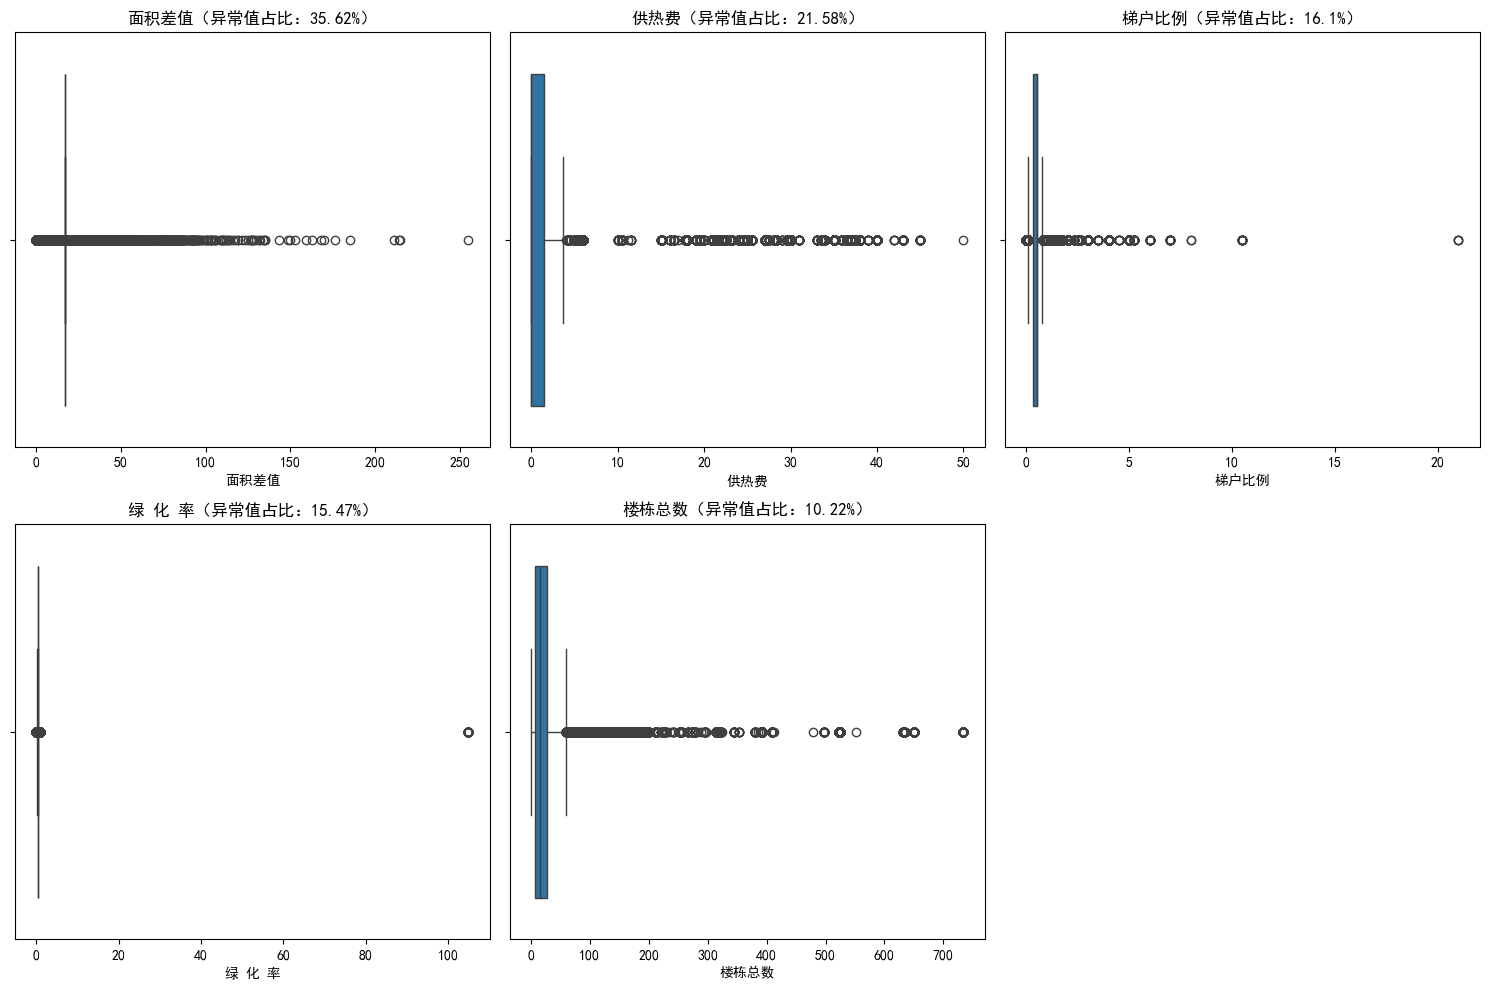


离散数值列取值范围检查：
城市：取值范围 0~11，常见值 [2, 3, 0]
区域：取值范围 3.0~131.0，常见值 [64.0, 86.0, 78.0]
区县：取值范围 3.0~131.0，常见值 [68.0, 64.0, 86.0]
板块_comm：取值范围 1.0~1186.0，常见值 [587.0, 349.0, 66.0]
开发商：取值范围 0~1，常见值 [1, 0]
物业公司：取值范围 0~1，常见值 [1, 0]
年份：取值范围 2015.0~2022.0，常见值 [2021.0, 2022.0, 2020.0]
房屋户型_数值和：取值范围 0~32，常见值 [5, 6, 8]
房屋朝向_朝南：取值范围 0~1，常见值 [1, 0]
交易权属_分级：取值范围 0~4，常见值 [4, 3, 1]
房屋用途_分级：取值范围 -1~2，常见值 [1, 0, 2]
建筑结构_comm_分级：取值范围 0~3，常见值 [2, 0, 1]
房屋优势_得分：取值范围 0.0~2.5，常见值 [1.0, 0.0, 0.5]
核心卖点_得分：取值范围 0.0~10.0，常见值 [0.0, 3.0, 2.0]
房型介绍_得分：取值范围 0.0~11.0，常见值 [0.0, 3.0, 2.0]
周边配套_得分：取值范围 0.0~12.0，常见值 [0.0, 3.0, 4.0]
交通出行_得分：取值范围 0.0~6.0，常见值 [0.0, 2.0, 3.0]
客户反馈_得分：取值范围 -6.0~5.0，常见值 [0.0, 1.0, -1.0]
交易年份：取值范围 2018~2025，常见值 [2024, 2023, 2025]
交易季度：取值范围 1~4，常见值 [3, 4, 1]
交易月份：取值范围 1~12，常见值 [12, 1, 9]


In [11]:
"""检查特征异常值并处理"""

# 设置中文显示
plt.rcParams["font.family"] = ["SimHei",]
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

# 定义特征类型（用于针对性检查）
continuous_cols = [  # 连续数值列（可能有极端值）
    'Price', '建筑面积', '套内面积', '梯户比例', '房屋年限', 'lon', 'lat', 
    '建筑年代', '房屋总数', '楼栋总数', '绿 化 率', '容 积 率', 
    '物 业 费', '燃气费', '供热费', '停车位', '停车费用', 'coord_x', 'coord_y', 
    '面积差值'
]
discrete_cols = [  # 离散数值列（取值范围有限）
    '城市', '区域', '区县', '板块_comm', '开发商', '物业公司', '年份',
    '房屋户型_数值和', '房屋朝向_朝南', '交易权属_分级', '房屋用途_分级', 
    '建筑结构_comm_分级', '房屋优势_得分', '核心卖点_得分', '房型介绍_得分', 
    '周边配套_得分', '交通出行_得分', '客户反馈_得分', '交易年份', '交易季度', '交易月份'
]

# 1. 连续数值列异常值检查（IQR法）
print("\n连续数值列异常值检查（IQR法）：")
iqr_results = {}
for col in continuous_cols:
    if col not in train_price.columns:
        continue
    q1 = train_price[col].quantile(0.25)
    q3 = train_price[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = train_price[(train_price[col] < lower) | (train_price[col] > upper)]
    outlier_ratio = len(outliers) / len(train_price) * 100
    iqr_results[col] = {
        '下界': lower, '上界': upper,
        '异常值数量': len(outliers), '异常值占比(%)': round(outlier_ratio, 2)
    }
    print(f"{col}：异常值占比 {outlier_ratio:.2f}%（上下界：{lower:.2f}~{upper:.2f}）")

# 可视化前5个异常值占比最高的连续列（箱线图）
top_outlier_cols = sorted(iqr_results.keys(), key=lambda x: iqr_results[x]['异常值占比(%)'], reverse=True)[:5]
plt.figure(figsize=(15, 10))
for i, col in enumerate(top_outlier_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=train_price[col])
    plt.title(f'{col}（异常值占比：{iqr_results[col]["异常值占比(%)"]}%）')
plt.tight_layout()
plt.show()

# 2. 离散数值列取值范围检查
print("\n离散数值列取值范围检查：")
for col in discrete_cols:
    if col not in train_price.columns:
        continue
    min_val = train_price[col].min()
    max_val = train_price[col].max()
    common_vals = train_price[col].value_counts().index[:3].tolist()
    print(f"{col}：取值范围 {min_val}~{max_val}，常见值 {common_vals}")

# 3. 所有数值列的描述性统计
# desc_stats = train_price.describe(include='all').T
# display(desc_stats[['count', 'mean', '50%', 'std', 'min', 'max', '25%', '75%']])

In [12]:
# 初始化字典，保存测试集需要的异常值处理阈值
train_outlier_thresholds = {}

# 1. 修正绿化率异常值（限制在0-1，符合比例逻辑）
if '绿 化 率' in train_price.columns:
    train_price['绿 化 率'] = train_price['绿 化 率'].clip(lower=0, upper=1)
    train_outlier_thresholds['绿 化 率'] = (0, 1)  # 保存上下限
    print("已修正绿化率异常值（范围限制在0-1，阈值已保存）")

# 2. 定义缩尾处理函数（用1%和99%分位数截断极端值）
def winsorize(col, lower_p=0.01, upper_p=0.99):
    lower = col.quantile(lower_p)
    upper = col.quantile(upper_p)
    return col.clip(lower=lower, upper=upper), (lower, upper)  # 返回处理后的数据和阈值

# 3. 梯户比例缩尾（保存阈值）
if '梯户比例' in train_price.columns:
    train_price['梯户比例'], thresholds = winsorize(train_price['梯户比例'])
    train_outlier_thresholds['梯户比例'] = thresholds  # 保存(1%分位数, 99%分位数)
    print("已对梯户比例进行缩尾处理，阈值已保存")

# 4. 物业费缩尾（保存阈值）
if '物 业 费' in train_price.columns:
    train_price['物 业 费'], thresholds = winsorize(train_price['物 业 费'])
    train_outlier_thresholds['物 业 费'] = thresholds  # 保存阈值
    print("已对物业费进行缩尾处理，阈值已保存")

# 5. 套内面积：负值用0代替
before_negative_area = len(train_price[train_price['套内面积'] < 0])
train_price.loc[train_price['套内面积'] < 0, '套内面积'] = 0
print(f"1. 套内面积：{before_negative_area} 条负值数据已替换为0")

# 6. 建筑年代：大于2021的改为2021（保存上限）
if '建筑年代' in train_price.columns:
    upper_limit = 2021
    before_future_year = len(train_price[train_price['建筑年代'] > upper_limit])
    train_price.loc[train_price['建筑年代'] > upper_limit, '建筑年代'] = upper_limit
    train_outlier_thresholds['建筑年代'] = upper_limit  # 保存上限
    print(f"2. 建筑年代：{before_future_year} 条未来年份数据已改为{upper_limit}，阈值已保存")

# 7. 容积率：用99%分位数截断（保存分位数）
if '容 积 率' in train_price.columns:
    # 计算训练集容积率99%分位数并保存
    train_volumetric_99 = train_price['容 积 率'].dropna().quantile(0.99)
    # 用该分位数截断训练集异常值
    before_high_volumetric = len(train_price[train_price['容 积 率'] > train_volumetric_99])
    train_price.loc[train_price['容 积 率'] > train_volumetric_99, '容 积 率'] = train_volumetric_99
    print(f"容积率：99%分位数为 {train_volumetric_99:.2f}，{before_high_volumetric} 条超上限数据已截断（已保存至train_volumetric_99）")

已修正绿化率异常值（范围限制在0-1，阈值已保存）
已对梯户比例进行缩尾处理，阈值已保存
已对物业费进行缩尾处理，阈值已保存
1. 套内面积：352 条负值数据已替换为0
2. 建筑年代：453 条未来年份数据已改为2021，阈值已保存
容积率：99%分位数为 8.50，976 条超上限数据已截断（已保存至train_volumetric_99）


In [13]:
# 其他异常值的出现都是因为数据本身的特点或者特殊的数据处理方式（如众数替代）导致的，因此不再做处理

In [14]:
from sklearn.model_selection import train_test_split

# 明确特征变量（X_price）和目标变量（y_price）
# 假设目标变量列为'Price'（需与实际数据中的房价列名一致）
X_price = train_price.drop(columns=['Price'])  # 房价特征矩阵（所有特征，排除目标变量）
y_price = train_price['Price']  # 房价目标变量

# 按8:2拆分，固定random_state=111确保可复现性
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(
    X_price, y_price,
    test_size=0.2,  # 测试集占比20%
    random_state=111  # 随机种子固定，拆分结果一致
)

# 输出拆分结果，验证比例
print("===== 房价数据集（train_price）拆分结果 =====")
print(f"训练集样本数：{X_train_price.shape[0]}（约80%），特征数：{X_train_price.shape[1]}")
print(f"测试集样本数：{X_test_price.shape[0]}（约20%），特征数：{X_test_price.shape[1]}")
print(f"训练集目标变量形状：{y_train_price.shape}，测试集目标变量形状：{y_test_price.shape}")
# 实际上应该叫验证集，在后面代码中进行了修改

===== 房价数据集（train_price）拆分结果 =====
训练集样本数：80604（约80%），特征数：85
测试集样本数：20151（约20%），特征数：85
训练集目标变量形状：(80604,)，测试集目标变量形状：(20151,)


### 测试集数据处理

In [15]:
"""转换数据类型（针对分类特征，转换为数值类型，与训练集同步，但无数据泄露）"""

print("销售测试集原始形状：", test_price.shape)

# 删除冗余列（训练集删除了“抵押信息”）
test_price = test_price.drop(columns=['抵押信息'], errors='ignore')

# 定义相同的转换函数
def convert_area(s):
    if pd.isna(s): return None
    s = str(s).strip()
    match = re.search(r'(\d+\.?\d*)', s)
    return float(match.group(1)) if match else None

# 先定义复合中文数字转换函数（与训练集完全一致）
def chinese_to_number(s):
    chinese_num = {
        '零': 0, '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9,
        '十': 10, '百': 100, '千': 1000, '万': 10000, '两': 2 
    }
    num = 0
    unit = 1  # 记录当前单位（十、百、千等）
    for c in reversed(s):  # 从右向左解析复合数字（如“十九”→10+9=19）
        if c in chinese_num:
            val = chinese_num[c]
            if val >= 10:  # 遇到“十、百、千”等单位
                unit = val
                if num == 0:  # 处理“十”单独出现的情况（如“十”=10）
                    num = 1
            else:  # 遇到“一、二、两...九”
                num += val * unit
        else:
            return None  # 非中文数字返回None
    return num if num != 0 else 0  # 避免空字符串返回0


# 梯户比例转换函数（与训练集逻辑完全一致）
def convert_ladder_household(s):
    if pd.isna(s):
        return None  # 缺失值返回None，后续统一填充
    s = str(s).strip()
    
    import re
    match = re.match(r'(.+)梯(.+)户', s)  # 严格匹配“X梯Y户”格式
    if not match:
        return None  # 不符合格式的返回None（如“3梯10户”已是数字的情况也会被正确处理）
    # 提取电梯数和户数的中文描述
    ladder_chinese = match.group(1).strip()  # 如“两”“三”
    household_chinese = match.group(2).strip()  # 如“十九”“二十四”
    # 转换为阿拉伯数字
    ladder = chinese_to_number(ladder_chinese)
    household = chinese_to_number(household_chinese)
    # 计算梯户比例（电梯数/户数）
    if ladder is not None and household is not None and household != 0:
        return ladder / household
    else:
        return None  # 转换失败返回None

def convert_house_age(s):
    mapping = {'未满两年':1, '满两年':2, '满五年':5}
    if pd.isna(s): return None
    s = str(s).strip()
    return mapping[s] if s in mapping else None

def convert_build_year(s):
    if pd.isna(s): return None
    match = re.findall(r'(\d{4})', str(s))
    return float(match[0]) if match else None

def convert_house_total(s):
    if pd.isna(s): return None
    match = re.search(r'(\d+)', str(s))
    return float(match.group(1)) if match else None

def convert_green_rate(s):
    if pd.isna(s): return None
    match = re.search(r'(\d+\.?\d*)%', str(s))
    return float(match.group(1))/100 if match else None

def convert_fee(s):
    if pd.isna(s): return None
    nums = re.findall(r'(\d+\.?\d*)', str(s))
    if len(nums) == 1:
        return float(nums[0])
    elif len(nums) >= 2:
        return (float(nums[0]) + float(nums[1])) / 2
    return None

def convert_parking_fee(s):
    if pd.isna(s): return None
    nums = re.findall(r'(\d+\.?\d*)', str(s))
    if nums:
        return sum(float(n) for n in nums) / len(nums)
    return None

# 应用转换函数
converters = {
    '建筑面积': convert_area,
    '套内面积': convert_area,
    '梯户比例': convert_ladder_household,
    '房屋年限': convert_house_age,
    '建筑年代': convert_build_year,
    '房屋总数': convert_house_total,
    '楼栋总数': convert_house_total,
    '绿 化 率': convert_green_rate,
    '物 业 费': convert_fee,
    '燃气费': convert_fee,
    '供热费': convert_fee,
    '停车费用': convert_parking_fee
}

for col, func in converters.items():
    if col in test_price.columns:
        test_price[col] = test_price[col].apply(func).astype(float)

# 删除冗余列
drop_cols = ['别墅类型', '物业办公电话', '环线位置']
test_price = test_price.drop(columns=drop_cols, errors='ignore')


"""缺失值填充（使用训练集的统计量，避免数据泄露）"""

# 1.套内面积填充
if all(c in test_price.columns for c in ['建筑面积', '套内面积']):
    has_inner = test_price['套内面积'].notna()
    median_diff = (train_price['建筑面积'] - train_price['套内面积']).median()  # 使用训练集中位差
    test_price.loc[~has_inner, '套内面积'] = test_price.loc[~has_inner, '建筑面积'] - median_diff

# 2.类别型缺失值处理
if '供暖' in test_price.columns:
    test_price['供暖'] = test_price['供暖'].fillna('无供暖')
if '供热费' in test_price.columns:
    test_price['供热费'] = test_price['供热费'].fillna(0)

for col in ['停车位', '停车费用', '梯户比例']:
    if col in test_price.columns:
        test_price[col] = test_price[col].fillna(0)

# 3.二元化物业公司、开发商
for col in ['物业公司', '开发商']:
    if col in test_price.columns:
        test_price[col] = test_price[col].fillna('无')
        test_price[col] = test_price[col].apply(lambda x: 0 if '无' in str(x) else 1)

# 4. 数值型填充：燃气费、物业费用0填充，其他用训练集中位数
median_vals = {
    '容 积 率': train_price['容 积 率'].median() if '容 积 率' in train_price.columns else None,
    '绿 化 率': train_price['绿 化 率'].median() if '绿 化 率' in train_price.columns else None
}
# 用中位数填充容积率、绿化率
for col, val in median_vals.items():
    if col in test_price.columns and val is not None:
        test_price[col] = test_price[col].fillna(val)

# 单独用0填充燃气费、物业费（用户指定）
for col in ['燃气费', '物 业 费']:
    if col in test_price.columns:
        test_price[col] = test_price[col].fillna(0)
        print(f"测试集{col}：用0填充缺失值")

# 5. 类别型填充：建筑结构、物业类别用"未知"，其他按原逻辑
# 测试集供水、供电缺失值填充为“未知”（与训练集一致）
for col in ['供水', '供电']:
    if col in test_price.columns:
        test_price[col] = test_price[col].fillna('未知')
        print(f"测试集{col}缺失值已填充为'未知'")

# 单独处理建筑结构、物业类别：用"未知"填充（不使用众数）
for col in ['建筑结构', '物业类别']:
    if col in test_price.columns:
        test_price[col] = test_price[col].fillna('未知')
        print(f"测试集{col}：用'未知'填充缺失值")

# 其他类别特征：用训练集保存的众数填充（排除建筑结构、物业类别）
other_cat_cols = ['产权描述', '装修情况', '房屋朝向', '房屋用途']  # 移除建筑结构、物业类别
for col in other_cat_cols:
    if col in test_price.columns and col in train_modes:
        test_price[col] = test_price[col].fillna(train_modes[col])
        print(f"测试集{col}：用训练集众数（{train_modes[col]}）填充")

if '配备电梯' in test_price.columns:
    test_price['配备电梯'] = test_price['配备电梯'].fillna('无')

# 6.交易时间与上次交易
for col in ['交易时间', '上次交易']:
    if col in test_price.columns:
        test_price[col] = pd.to_datetime(test_price[col], errors='coerce')
if all(c in test_price.columns for c in ['交易时间', '上次交易']):
    test_price['上次交易'] = test_price['上次交易'].fillna(test_price['交易时间'])

# 7. 房屋年限和建筑年代填充
if '房屋年限' in test_price.columns:
    # 1. 填充缺失值为“未知”（与训练集逻辑一致）
    test_price['房屋年限'] = test_price['房屋年限'].apply(
        lambda x: str(int(x)) if pd.notna(x) else '未知'
    )
    print("测试集房屋年限：缺失值已填充为'未知'，并转换为字符串类型")
    # 2. 对测试集进行独热编码，并对齐训练集的房屋年限独热列
    test_age_encoded = pd.get_dummies(test_price, columns=['房屋年限'], prefix='房屋年限', drop_first=True)
    # 补充训练集有但测试集没有的房屋年限独热列（填0）
    missing_age_cols = set(age_onehot_cols) - set(test_age_encoded.columns)
    for col in missing_age_cols:
        test_age_encoded[col] = 0
    # 仅保留原始列+房屋年限独热列
    test_price = test_age_encoded
    print("测试集房屋年限独热编码完成（已对齐房屋年限相关列）")

if all(c in test_price.columns for c in ['建筑年代', '上次交易']):
    last_trade_year = test_price['上次交易'].dt.year
    test_price['建筑年代'] = test_price.apply(
        lambda row: last_trade_year[row.name] - 3 if pd.isna(row['建筑年代']) else row['建筑年代'],
        axis=1
    )

# 8. 剩余数值型特征：用训练集中位数填充
num_cols = test_price.select_dtypes(include=['int64', 'float64']).columns.tolist()
processed_num = ['绿化率', '梯户比例', '物 业 费', '套内面积', '供热费', '停车位', '停车费用', 
                 '容积率', '燃气费', '房屋年限', '建筑年代']
remaining_num = [col for col in num_cols if col not in processed_num and col in train_medians]

for col in remaining_num:
    test_price[col] = test_price[col].fillna(train_medians[col])
    print(f"测试集{col}：用训练集中位数（{train_medians[col]:.2f}）填充缺失值")


# 9. 其他特征填充（与训练集一致）
if '房屋户型' in test_price.columns:
    test_price['房屋户型'] = test_price['房屋户型'].fillna(train_modes['房屋户型'])
    print(f"测试集房屋户型：用训练集众数（{train_modes['房屋户型']}）填充")

if '环线' in test_price.columns:
    test_price['环线'] = test_price['环线'].fillna('未知')  # 与训练集一致
    print("测试集环线：缺失值填充为'未知'")

for col in ['房屋优势', '核心卖点', '户型介绍', '周边配套', '交通出行']:
    if col in test_price.columns:
        test_price[col] = test_price[col].fillna('无描述')
print("测试集文本特征：缺失值填充为'无描述'")

# 检查剩余缺失值
print("\n测试集剩余缺失值：")
print(test_price.isnull().sum()[test_price.isnull().sum() > 0])
print(test_price.columns.tolist())

销售测试集原始形状： (34017, 55)
测试集燃气费：用0填充缺失值
测试集物 业 费：用0填充缺失值
测试集供水缺失值已填充为'未知'
测试集供电缺失值已填充为'未知'
测试集建筑结构：用'未知'填充缺失值
测试集物业类别：用'未知'填充缺失值
测试集产权描述：用训练集众数（商品房）填充
测试集装修情况：用训练集众数（精装）填充
测试集房屋朝向：用训练集众数（南）填充
测试集房屋用途：用训练集众数（普通住宅）填充
测试集房屋年限：缺失值已填充为'未知'，并转换为字符串类型
测试集房屋年限独热编码完成（已对齐房屋年限相关列）
测试集城市：用训练集中位数（3.00）填充缺失值
测试集区域：用训练集中位数（68.00）填充缺失值
测试集板块：用训练集中位数（591.00）填充缺失值
测试集建筑面积：用训练集中位数（91.00）填充缺失值
测试集lon：用训练集中位数（115.93）填充缺失值
测试集lat：用训练集中位数（32.14）填充缺失值
测试集年份：用训练集中位数（2021.00）填充缺失值
测试集区县：用训练集中位数（68.00）填充缺失值
测试集板块_comm：用训练集中位数（587.00）填充缺失值
测试集房屋总数：用训练集中位数（1372.00）填充缺失值
测试集楼栋总数：用训练集中位数（15.00）填充缺失值
测试集绿 化 率：用训练集中位数（0.34）填充缺失值
测试集容 积 率：用训练集中位数（2.50）填充缺失值
测试集coord_x：用训练集中位数（117.03）填充缺失值
测试集coord_y：用训练集中位数（32.17）填充缺失值
测试集房屋户型：用训练集众数（2室1厅1厨1卫）填充
测试集环线：缺失值填充为'未知'
测试集文本特征：缺失值填充为'无描述'

测试集剩余缺失值：
建筑结构_comm    7834
dtype: int64
['ID', '城市', '区域', '板块', '环线', '房屋户型', '所在楼层', '建筑面积', '套内面积', '房屋朝向', '建筑结构', '装修情况', '梯户比例', '配备电梯', '交易时间', '交易权属', '上次交易', '房屋用途', '产权所属', '房屋优势', '核心卖点', '户型介绍', '周边配套', '交通出行', 'lon', 'lat', '年份'

In [16]:
"""转换数据类型（针对分类特征，转换为数值类型，与训练集编码规则一致）"""

# 1. 低基数特征One-Hot编码（基于训练集的类别）
low_cardinal_cols = [
    '建筑结构', '装修情况', '配备电梯', '产权所属', 
    '供水', '供暖', '供电'
]

# 生成训练集的One-Hot列名作为基准
train_onehot_cols = [col for col in train_price.columns if any(col.startswith(c) for c in low_cardinal_cols)]

# 对测试集编码后，对齐训练集的列（缺失列填0），并转为副本避免视图警告
test_encoded = pd.get_dummies(test_price, columns=low_cardinal_cols, drop_first=True)
missing_onehot = set(train_onehot_cols) - set(test_encoded.columns)
for col in missing_onehot:
    test_encoded[col] = 0
# 关键：添加.copy()确保test_price是独立DataFrame
test_price = test_encoded[train_onehot_cols + [col for col in test_encoded.columns if col not in train_onehot_cols and col not in low_cardinal_cols]].copy()
print(f"低基数特征One-Hot编码后，测试集形状：{test_price.shape}")

# 2. 房屋户型：提取数字求和（复用训练集函数）
# 使用.loc明确赋值，避免链式索引警告
test_price.loc[:, '房屋户型_数值和'] = test_price['房屋户型'].apply(process_house_type)  # 复用训练集的process_house_type
test_price = test_price.drop(columns=['房屋户型'], errors='ignore').copy()  # 再次转为副本
print("测试集房屋户型：提取数字求和")

# 3. 所在楼层：关键字分类+One-Hot（复用训练集函数和编码列）
test_price.loc[:, '所在楼层_分类'] = test_price['所在楼层'].apply(process_floor)  # 复用process_floor
train_floor_cols = [col for col in train_price.columns if col.startswith('楼层_')]
test_floor_encoded = pd.get_dummies(test_price, columns=['所在楼层_分类'], prefix='楼层', drop_first=True)
missing_floor = set(train_floor_cols) - set(test_floor_encoded.columns)
for col in missing_floor:
    test_floor_encoded[col] = 0
# 关键：添加.copy()
test_price = test_floor_encoded[train_floor_cols + [col for col in test_floor_encoded.columns if col not in train_floor_cols and col != '所在楼层']].copy()
test_price = test_price.drop(columns=['所在楼层'], errors='ignore').copy()
print("测试集所在楼层：关键字分类+One-Hot编码")

# 4. 房屋朝向：是否含南（复用函数）
test_price.loc[:, '房屋朝向_朝南'] = test_price['房屋朝向'].apply(process_orientation)  # 复用process_orientation
test_price = test_price.drop(columns=['房屋朝向'], errors='ignore').copy()
print("测试集房屋朝向：生成'房屋朝向_朝南'")

# 5. 交易权属：分级（复用函数）
test_price.loc[:, '交易权属_分级'] = test_price['交易权属'].apply(process_transaction_rights)  # 复用
test_price = test_price.drop(columns=['交易权属'], errors='ignore').copy()
print("测试集交易权属：生成'交易权属_分级'")

# 6. 房屋用途：分级（复用函数）
test_price.loc[:, '房屋用途_分级'] = test_price['房屋用途'].apply(process_house_use)  # 复用
test_price = test_price.drop(columns=['房屋用途'], errors='ignore').copy()
print("测试集房屋用途：生成'房屋用途_分级'")

# 7. 物业类别：是否含别墅（复用函数）
test_price.loc[:, '物业类别_含别墅'] = test_price['物业类别'].apply(process_property_type)  # 复用
test_price = test_price.drop(columns=['物业类别'], errors='ignore').copy()
print("测试集物业类别：生成'物业类别_含别墅'")

# 8. 建筑结构_comm：分级（复用函数）
test_price.loc[:, '建筑结构_comm_分级'] = test_price['建筑结构_comm'].apply(process_structure)  # 复用
test_price = test_price.drop(columns=['建筑结构_comm'], errors='ignore').copy()
print("测试集建筑结构_comm：生成'建筑结构_comm_分级'")

# 9. 产权描述：是否含商品房（复用函数）
test_price.loc[:, '产权描述_含商品房'] = test_price['产权描述'].apply(process_property_desc)  # 复用
test_price = test_price.drop(columns=['产权描述'], errors='ignore').copy()
print("测试集产权描述：生成'产权描述_含商品房'")

# 10. 环线：One-Hot编码（对齐训练集列）
train_ring_cols = [col for col in train_price.columns if col.startswith('环线_')]
test_ring_encoded = pd.get_dummies(test_price, columns=['环线'], prefix='环线', drop_first=True)
missing_ring = set(train_ring_cols) - set(test_ring_encoded.columns)
for col in missing_ring:
    test_ring_encoded[col] = 0
# 关键：添加.copy()
test_price = test_ring_encoded[train_ring_cols + [col for col in test_ring_encoded.columns if col not in train_ring_cols and col != '环线']].copy()
print("测试集环线：One-Hot编码")

低基数特征One-Hot编码后，测试集形状：(34017, 70)
测试集房屋户型：提取数字求和
测试集所在楼层：关键字分类+One-Hot编码
测试集房屋朝向：生成'房屋朝向_朝南'
测试集交易权属：生成'交易权属_分级'
测试集房屋用途：生成'房屋用途_分级'
测试集物业类别：生成'物业类别_含别墅'
测试集建筑结构_comm：生成'建筑结构_comm_分级'
测试集产权描述：生成'产权描述_含商品房'
测试集环线：One-Hot编码


In [17]:
# 文本特征处理（复用训练集函数）

# 1. 房屋优势得分
test_price['房屋优势_得分'] = test_price['房屋优势'].apply(calculate_house_advantage_score)  # 复用
test_price = test_price.drop(columns=['房屋优势'], errors='ignore')

# 2. 核心卖点得分
test_price['核心卖点_得分'] = test_price['核心卖点'].apply(process_core_selling_points)  # 复用
test_price = test_price.drop(columns=['核心卖点'], errors='ignore')

# 3. 房型介绍得分
test_price['房型介绍_得分'] = test_price['户型介绍'].apply(process_house_layout)  # 复用
test_price = test_price.drop(columns=['户型介绍'], errors='ignore')

# 4. 周边配套得分
test_price['周边配套_得分'] = test_price['周边配套'].apply(process_surrounding_facilities)  # 复用
test_price = test_price.drop(columns=['周边配套'], errors='ignore')

# 5. 交通出行得分
test_price['交通出行_得分'] = test_price['交通出行'].apply(process_transportation)  # 复用
test_price = test_price.drop(columns=['交通出行'], errors='ignore')

# 6. 客户反馈得分
test_price['客户反馈_得分'] = test_price['客户反馈'].apply(process_customer_feedback)  # 复用
test_price = test_price.drop(columns=['客户反馈'], errors='ignore')

print("测试集文本特征处理完成，形状：", test_price.shape)

# 时间特征提取（与训练集一致）

if '交易时间' in test_price.columns:
    test_price['交易年份'] = test_price['交易时间'].dt.year
    test_price['交易季度'] = test_price['交易时间'].dt.quarter
    test_price['交易月份'] = test_price['交易时间'].dt.month

# 计算持有年限
if '上次交易' in test_price.columns and '交易时间' in test_price.columns:
    test_price['持有年限'] = (test_price['交易时间'] - test_price['上次交易']).dt.days / 365
    test_price['持有年限'] = test_price['持有年限'].clip(lower=0)  # 负值处理为0
    test_price = test_price.drop(columns=['交易时间', '上次交易'], errors='ignore')
else:
    test_price = test_price.drop(columns=['交易时间', '上次交易'], errors='ignore')

print("测试集时间特征提取完成")

测试集文本特征处理完成，形状： (34017, 83)
测试集时间特征提取完成


In [18]:
"""处理异常值（严格复用训练集阈值，避免数据泄露）"""

# 检查训练集阈值字典是否存在（确保训练集已保存）
if 'train_outlier_thresholds' not in globals():
    raise ValueError("请先在训练集代码中定义并保存train_outlier_thresholds字典")

# 1. 绿化率：使用训练集保存的0-1范围
if '绿 化 率' in test_price.columns and '绿 化 率' in train_outlier_thresholds:
    lower, upper = train_outlier_thresholds['绿 化 率']  # 从训练集阈值取(0,1)
    test_price['绿 化 率'] = test_price['绿 化 率'].clip(lower=lower, upper=upper)
    print("测试集绿化率：已用训练集阈值(0-1)修正异常值")

# 2. 梯户比例：使用训练集1%和99%分位数缩尾
if '梯户比例' in test_price.columns and '梯户比例' in train_outlier_thresholds:
    lower, upper = train_outlier_thresholds['梯户比例']  # 复用训练集缩尾阈值
    test_price['梯户比例'] = test_price['梯户比例'].clip(lower=lower, upper=upper)
    print(f"测试集梯户比例：已用训练集阈值({lower:.4f}-{upper:.4f})缩尾处理")

# 3. 物业费：使用训练集1%和99%分位数缩尾
if '物 业 费' in test_price.columns and '物 业 费' in train_outlier_thresholds:
    lower, upper = train_outlier_thresholds['物 业 费']  # 复用训练集缩尾阈值
    test_price['物 业 费'] = test_price['物 业 费'].clip(lower=lower, upper=upper)
    print(f"测试集物业费：已用训练集阈值({lower:.4f}-{upper:.4f})缩尾处理")

# 4. 套内面积：负值转0
if '套内面积' in test_price.columns:
    negative_count = len(test_price[test_price['套内面积'] < 0])
    test_price.loc[test_price['套内面积'] < 0, '套内面积'] = 0
    print(f"测试集套内面积：{negative_count}条负值数据已转为0")

# 5. 建筑年代：大于训练集上限2021的转2021
if '建筑年代' in test_price.columns and '建筑年代' in train_outlier_thresholds:
    upper_limit = train_outlier_thresholds['建筑年代']  # 复用训练集上限2021
    future_count = len(test_price[test_price['建筑年代'] > upper_limit])
    test_price.loc[test_price['建筑年代'] > upper_limit, '建筑年代'] = upper_limit
    print(f"测试集建筑年代：{future_count}条超{upper_limit}的数据已修正为{upper_limit}")

# 6. 容积率：用训练集99%分位数截断
if '容 积 率' in test_price.columns and '容 积 率_99' in train_outlier_thresholds:
    volumetric_99 = train_outlier_thresholds['容 积 率_99']  # 复用训练集99%分位数
    high_count = len(test_price[test_price['容 积 率'] > volumetric_99])
    test_price.loc[test_price['容 积 率'] > volumetric_99, '容 积 率'] = volumetric_99
    print(f"测试集容积率：99%分位数阈值为{volumetric_99:.2f}，{high_count}条超上限数据已截断")

print("测试集异常值处理完成（所有阈值均复用训练集，无数据泄露）")

测试集绿化率：已用训练集阈值(0-1)修正异常值
测试集梯户比例：已用训练集阈值(0.0000-3.0000)缩尾处理
测试集物业费：已用训练集阈值(0.0000-11.6000)缩尾处理
测试集套内面积：0条负值数据已转为0
测试集建筑年代：3165条超2021的数据已修正为2021
测试集异常值处理完成（所有阈值均复用训练集，无数据泄露）


In [19]:
# 【新增步骤】在特征对齐前，单独保存测试集的ID列
test_ids = test_price['ID'].copy()  # 对齐前提取ID，避免后续被删除

# 最终对齐：确保测试集特征与训练集完全一致

# 按训练集特征列顺序对齐，缺失特征填0
train_final_cols = X_train_price.columns.tolist()  # 训练集最终特征列
test_price = test_price.reindex(columns=train_final_cols, fill_value=0)

print("\n测试集处理完成！最终形状：", test_price.shape)
print("测试集特征数与训练集是否一致：", test_price.shape[1] == len(train_final_cols))

# 输出最终数据（用于建模）
X_test_final = test_price
print(X_test_final.columns.tolist())


测试集处理完成！最终形状： (34017, 85)
测试集特征数与训练集是否一致： True
['城市', '区域', '板块', '建筑面积', '套内面积', '梯户比例', 'lon', 'lat', '年份', '区县', '板块_comm', '建筑年代', '开发商', '房屋总数', '楼栋总数', '物业公司', '绿 化 率', '容 积 率', '物 业 费', '燃气费', '供热费', '停车位', '停车费用', 'coord_x', 'coord_y', '面积差值', '房屋年限_2', '房屋年限_5', '房屋年限_未知', '建筑结构_未知结构', '建筑结构_框架结构', '建筑结构_混合结构', '建筑结构_砖木结构', '建筑结构_砖混结构', '建筑结构_钢混结构', '建筑结构_钢结构', '装修情况_毛坯', '装修情况_简装', '装修情况_精装', '配备电梯_有', '产权所属_非共有', '供水_商水/民水', '供水_未知', '供水_民水', '供暖_自采暖', '供暖_自采暖/无供暖', '供暖_集中供暖', '供暖_集中供暖/自采暖', '供暖_集中供暖/自采暖/无供暖', '供电_商电/民电', '供电_未知', '供电_民电', '房屋户型_数值和', '楼层_低', '楼层_地', '楼层_底', '楼层_顶', '楼层_高', '房屋朝向_朝南', '交易权属_分级', '房屋用途_分级', '物业类别_含别墅', '建筑结构_comm_分级', '产权描述_含商品房', '环线_中环至外环', '环线_二环内', '环线_二至三环', '环线_五至六环', '环线_六环外', '环线_内环内', '环线_内环至中环', '环线_内环至外环', '环线_四至五环', '环线_外环外', '环线_未知', '房屋优势_得分', '核心卖点_得分', '房型介绍_得分', '周边配套_得分', '交通出行_得分', '客户反馈_得分', '交易年份', '交易季度', '交易月份', '持有年限']


In [20]:
# 查看train和test的列名差异
train_cols = set(train_final_cols)  
test_cols = set(test_price.columns)  # 替换为实际的测试集变量test_price

# train有但test没有的列
missing_in_test = train_cols - test_cols
print(f"train有但test没有的列（{len(missing_in_test)}个）：\n{missing_in_test}")

# test有但train没有的列
extra_in_test = test_cols - train_cols
print(f"\ntest有但train没有的列（{len(extra_in_test)}个）：\n{extra_in_test}")

train有但test没有的列（0个）：
set()

test有但train没有的列（0个）：
set()


## step 2 特征工程

数值型且全为正数的特征：['区域', '板块', '建筑面积', 'lon', 'lat', '年份', '区县', '板块_comm', '建筑年代', '房屋总数', '楼栋总数', '绿 化 率', '容 积 率', 'coord_x', 'coord_y']
各特征偏度（绝对值）排序：
楼栋总数       6.652664
房屋总数       2.311157
建筑面积       2.225841
容 积 率      2.225372
建筑年代       1.728654
年份         1.044555
coord_x    0.476974
lon        0.380825
绿 化 率      0.379140
lat        0.248616
coord_y    0.233438
区域         0.116674
区县         0.072972
板块_comm    0.024366
板块         0.004608
dtype: float64


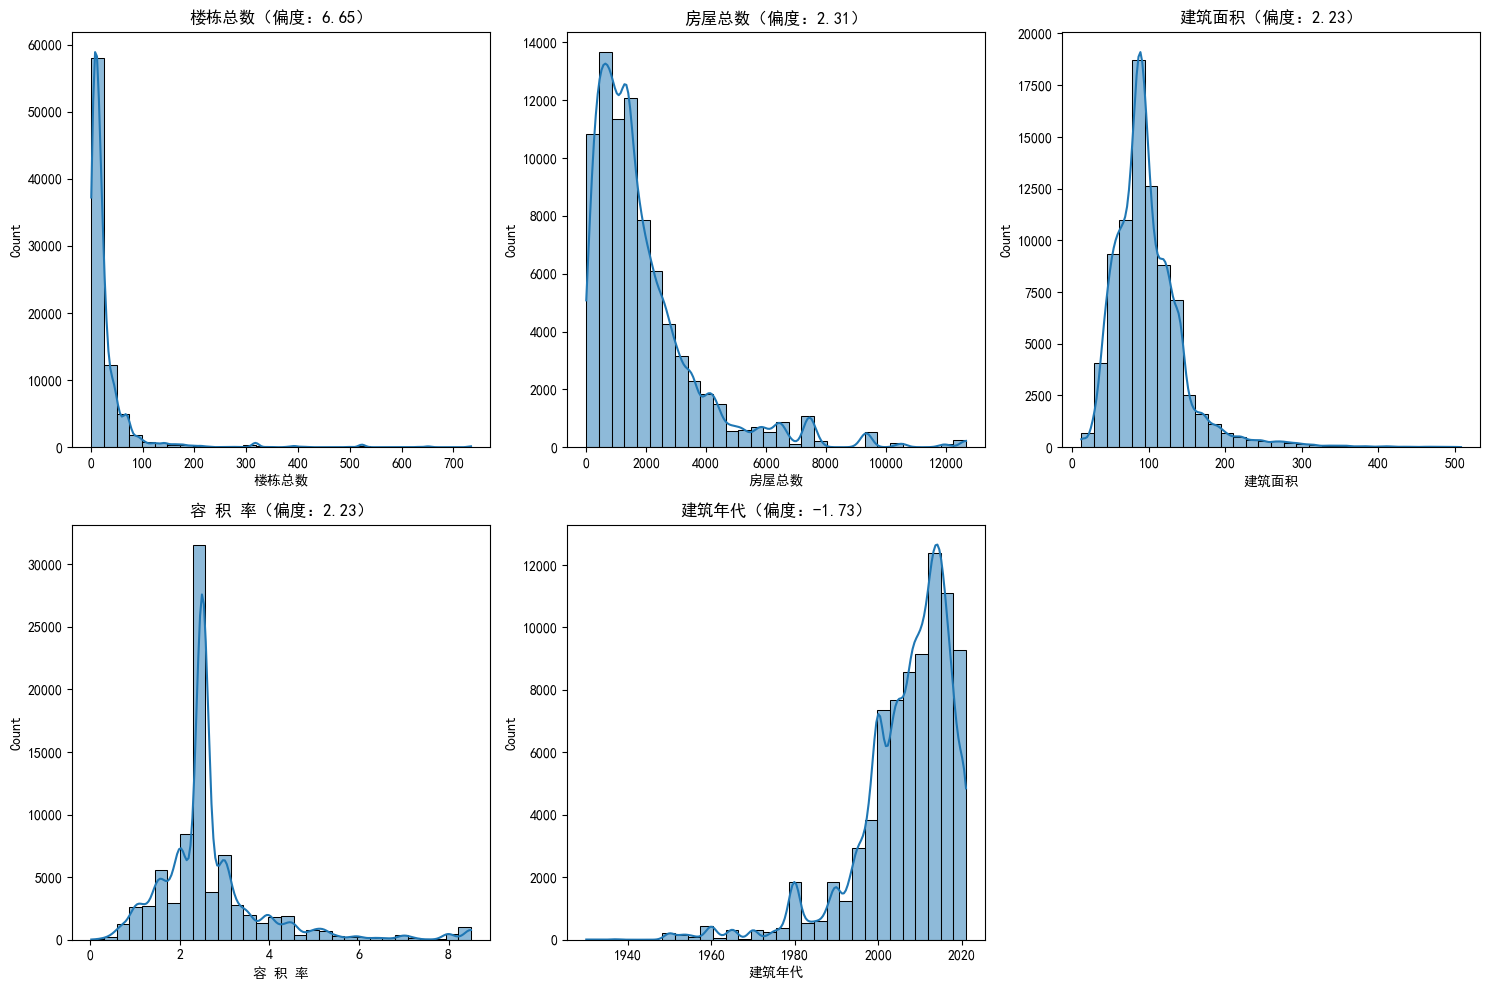

In [21]:
"""计算偏度进行对数变换"""
# 筛选数值型特征（排除字符串、布尔型等）
numeric_cols = X_train_price.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 排除取值含0或负数的特征（避免Log变换报错）
positive_cols = []
for col in numeric_cols:
    # 检查是否所有值都>0（允许极小正数）
    if (X_train_price[col] > 0).all():
        positive_cols.append(col)

print(f"数值型且全为正数的特征：{positive_cols}")

# 计算每个正数值特征的偏度
skewness = X_train_price[positive_cols].skew()

# 按偏度绝对值从大到小排序
skewness_sorted = skewness.abs().sort_values(ascending=False)
print("各特征偏度（绝对值）排序：")
print(skewness_sorted)

# 选择偏度绝对值前5的特征进行可视化
top_skewed = skewness_sorted.index[:5].tolist()

# 绘制直方图+核密度图
plt.figure(figsize=(15, 10))
for i, col in enumerate(top_skewed, 1):
    plt.subplot(2, 3, i)
    sns.histplot(X_train_price[col], kde=True, bins=30)
    plt.title(f"{col}（偏度：{skewness[col]:.2f}）")
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [22]:
# 最终确定的Log变换特征
skewed_features = [
    '楼栋总数', '物 业 费', '房屋总数', 
    '建筑面积', '容 积 率'
]
print(f"需要做Log变换的特征：{skewed_features}")

# 训练集Log变换
X_train_fe = X_train_price.copy()
for col in skewed_features:
    X_train_fe[f'{col}_log'] = np.log1p(X_train_fe[col])

# 验证集（X_test_price）Log变换
X_val_fe = X_test_price.copy()  # 明确20%为验证集，命名为X_val_fe
for col in skewed_features:
    X_val_fe[f'{col}_log'] = np.log1p(X_val_fe[col])

# 真正测试集（X_test_final）Log变换
X_test_final_fe = X_test_final.copy()  # 真正测试集命名统一
for col in skewed_features:
    X_test_final_fe[f'{col}_log'] = np.log1p(X_test_final_fe[col])

print(f"已完成{len(skewed_features)}个特征的Log变换，新增{len(skewed_features)}个特征")

需要做Log变换的特征：['楼栋总数', '物 业 费', '房屋总数', '建筑面积', '容 积 率']
已完成5个特征的Log变换，新增5个特征


In [23]:
"""创建平方项（所有数据集同步）"""
# 1. 物业费_log²（基于Log变换后的特征计算平方）
X_train_fe['物 业 费_log_平方'] = X_train_fe['物 业 费_log'] **2
X_val_fe['物 业 费_log_平方'] = X_val_fe['物 业 费_log']** 2
X_test_final_fe['物 业 费_log_平方'] = X_test_final_fe['物 业 费_log'] **2

# 2. 容积率_log²（基于Log变换后的特征计算平方）
X_train_fe['容 积 率_log_平方'] = X_train_fe['容 积 率_log']** 2
X_val_fe['容 积 率_log_平方'] = X_val_fe['容 积 率_log'] **2
X_test_final_fe['容 积 率_log_平方'] = X_test_final_fe['容 积 率_log']** 2

print(f"已添加2个平方项：物 业 费_log_平方、容 积 率_log_平方")

已添加2个平方项：物 业 费_log_平方、容 积 率_log_平方


In [24]:
"""计算相关性"""
# ----------------------
# 计算每个特征与房价（y_train_price）的相关性（取绝对值）
corr_with_target = X_train_fe.apply(
    lambda x: x.corr(y_train_price, method='pearson')
).abs().reset_index()

# 重命名列名
corr_with_target.columns = ['特征名称', '与房价的相关系数（绝对值）']

# 按相关性从低到高排序
corr_sorted = corr_with_target.sort_values(by='与房价的相关系数（绝对值）', ascending=True)
pd.set_option('display.max_rows', None)
print("特征与房价的相关性（从低到高排序）：")
print(corr_sorted)

特征与房价的相关性（从低到高排序）：
               特征名称  与房价的相关系数（绝对值）
40         产权所属_非共有       0.000540
48  供暖_集中供暖/自采暖/无供暖       0.003688
32        建筑结构_砖木结构       0.004052
73           环线_外环外       0.006370
37          装修情况_简装       0.006726
54             楼层_地       0.011136
63        产权描述_含商品房       0.011904
69           环线_内环内       0.011932
45       供暖_自采暖/无供暖       0.013768
68           环线_六环外       0.016578
53             楼层_低       0.018483
59          交易权属_分级       0.019365
26           房屋年限_2       0.019705
80          客户反馈_得分       0.021175
79          交通出行_得分       0.023330
78          周边配套_得分       0.023331
21              停车位       0.024095
64         环线_中环至外环       0.025539
49         供电_商电/民电       0.027231
41         供水_商水/民水       0.029342
39           配备电梯_有       0.030525
76          核心卖点_得分       0.030565
43            供水_民水       0.031755
17            容 积 率       0.032209
82             交易季度       0.032649
14             楼栋总数       0.033784
51            供电_民电       0.033969
3

In [25]:
"""删除低相关特征"""
to_drop = [
    # 热编码子项
    '产权所属_非共有',
    '供暖_集中供暖/自采暖/无供暖', '供暖_自采暖/无供暖',
    '建筑结构_砖木结构', '建筑结构_钢混结构',
    '环线_外环外', '环线_内环内', '环线_六环外', '环线_中环至外环',
    '装修情况_简装',
    '楼层_地', '楼层_低', '配备电梯_有',
    '产权描述_含商品房',
    '供水_民水', '供水_商水/民水', '供水_未知',
    
    # 非热编码特征
    '停车位',  '交易权属_分级',
    '楼栋总数', '物 业 费', '房屋总数_log', '建筑面积', '容 积 率',
    '板块_comm', '交易季度', '交易月份', '物业类别_含别墅',
]

# 训练集
X_train_selected = X_train_fe.drop(columns=to_drop, errors='ignore')
# 验证集
X_val_selected = X_val_fe.drop(columns=to_drop, errors='ignore')
# 真正测试集
X_test_final_selected = X_test_final_fe.drop(columns=to_drop, errors='ignore')

print(f"删除后训练集特征数：{X_train_selected.shape[1]}")
print(f"删除后验证集特征数：{X_val_selected.shape[1]}")
print(f"删除后真正测试集特征数：{X_test_final_selected.shape[1]}")

删除后训练集特征数：64
删除后验证集特征数：64
删除后真正测试集特征数：64


In [26]:
"""处理高相关特征"""
# ----------------------
# 计算特征间的相关性矩阵（取绝对值）
corr_matrix = X_train_selected.corr().abs()

# 找出相关系数>0.85的特征对（排除对角线）
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.85: 
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

print(f"发现{len(high_corr_pairs)}对高度相关特征：")
for pair in high_corr_pairs:
    print(pair)

发现7对高度相关特征：
('区域', '区县')
('套内面积', '建筑面积_log')
('lon', 'coord_x')
('lat', 'coord_y')
('年份', '交易年份')
('物 业 费_log', '物 业 费_log_平方')
('容 积 率_log', '容 积 率_log_平方')


In [27]:
# 删除高相关特征（所有数据集同步）
drop_high_corr = ['区县', '套内面积', 'coord_x', 'coord_y', '交易年份', '物 业 费_log' , '容 积 率_log']

# 训练集
X_train_final = X_train_selected.drop(columns=drop_high_corr, errors='ignore')
# 验证集
X_val_final = X_val_selected.drop(columns=drop_high_corr, errors='ignore')
# 真正测试集
X_test_final = X_test_final_selected.drop(columns=drop_high_corr, errors='ignore')  # 覆盖原X_test_final，保持命名一致

print(f"高相关特征删除后：训练集特征数{X_train_final.shape[1]}，验证集特征数{X_val_final.shape[1]}, 真正测试集特征数{X_test_final.shape[1]}")

高相关特征删除后：训练集特征数57，验证集特征数57, 真正测试集特征数57


In [28]:
"""vif检验"""
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    """计算特征的方差膨胀因子（VIF），仅适用于数值型特征"""
    # 确保输入为数值型特征（VIF不支持类别型）
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    vif_df = pd.DataFrame()
    vif_df["特征名称"] = numeric_df.columns
    # 计算每个特征的VIF
    vif_df["VIF值"] = [
        variance_inflation_factor(numeric_df.values, i) 
        for i in range(numeric_df.shape[1])
    ]
    return vif_df.sort_values(by="VIF值", ascending=False)  # 按VIF从高到低排序

# 基于训练集最终特征（X_train_final）计算VIF（避免数据泄露）
vif_results = calculate_vif(X_train_final)

# 打印VIF结果，重点关注高VIF特征（通常VIF>10表示共线性较高，VIF>30为严重共线性）
print("\n【VIF多重共线性检测结果（从高到低排序）】")
pd.set_option('display.max_rows', None)  # 显示所有特征的VIF
display(vif_results)

# 提取VIF>10的高共线性特征（可根据实际情况调整阈值）
high_vif_features = vif_results[vif_results["VIF值"] > 10]["特征名称"].tolist()
print(f"\nVIF>10的高共线性特征（共{len(high_vif_features)}个）：")
print(high_vif_features)


【VIF多重共线性检测结果（从高到低排序）】


,特征名称,VIF值
7,建筑年代,53629.973283
6,年份,52568.905991
4,lon,806.736223
28,建筑面积_log,429.654325
5,lat,158.581356
16,房屋户型_数值和,44.412357
11,绿 化 率,21.383458
27,楼栋总数_log,17.442255
18,房屋用途_分级,16.253751
12,燃气费,9.575367



VIF>10的高共线性特征（共9个）：
['建筑年代', '年份', 'lon', '建筑面积_log', 'lat', '房屋户型_数值和', '绿 化 率', '楼栋总数_log', '房屋用途_分级']


In [29]:
# 定义需要删除的特征
to_drop_vif = [ '面积差值', '燃气费','持有年限','lat', '产权描述_含商品房']
# 以上有些是因调整模型的需要而删除的特征
# 同步删除训练集、验证集、测试集的特征
X_train_final_vif = X_train_final.drop(columns=to_drop_vif, errors='ignore')
X_val_final_vif = X_val_final.drop(columns=to_drop_vif, errors='ignore')
X_test_final_vif = X_test_final.drop(columns=to_drop_vif, errors='ignore')

# 重新计算VIF（基于删除后的训练集特征）
vif_updated = calculate_vif(X_train_final_vif)

# 输出删除后的VIF结果（从高到低排序）
print("【删除指定特征后的VIF多重共线性检测结果（从高到低排序）】")
print("注：VIF>10表示共线性较高，VIF>30表示严重共线性")
pd.set_option('display.max_rows', None)
display(vif_updated)

# 用删除高VIF特征后的数据集覆盖原始变量名，确保后续步骤使用的是删除后的特征
X_train_final = X_train_final_vif
X_val_final = X_val_final_vif
X_test_final = X_test_final_vif
print(f"覆盖后：训练集特征数{X_train_final.shape[1]}，验证集特征数{X_val_final.shape[1]}, 真正测试集特征数{X_test_final.shape[1]}")

【删除指定特征后的VIF多重共线性检测结果（从高到低排序）】
注：VIF>10表示共线性较高，VIF>30表示严重共线性


,特征名称,VIF值
6,建筑年代,46414.017178
5,年份,45902.871468
4,lon,638.399137
24,建筑面积_log,401.058814
13,房屋户型_数值和,43.062392
10,绿 化 率,21.343170
23,楼栋总数_log,17.198906
15,房屋用途_分级,15.988921
9,物业公司,7.675526
7,开发商,6.852516


覆盖后：训练集特征数53，验证集特征数53, 真正测试集特征数53


In [30]:
"""处理年份特征，进行独热编码"""
def encode_year_feature(train_df, val_df, test_df, year_col='年份'):
    # 暂存测试集的ID列
    test_id = test_df['ID'] if 'ID' in test_df.columns else None
    
    # 1. 对训练集进行独热编码（基于训练集的年份类别，作为基准）
    train_encoded = pd.get_dummies(train_df, columns=[year_col], prefix='year', drop_first=True)
    
    # 2. 提取训练集生成的年份独热特征列（作为标准列名）
    year_features = [col for col in train_encoded.columns if col.startswith('year_')]
    print(f"基于训练集生成的年份独热特征数：{len(year_features)}（总年份数-1）")
    
    # 3. 处理验证集：对齐训练集列，缺失年份类别填0
    val_encoded = pd.get_dummies(val_df, columns=[year_col], prefix='year', drop_first=True)
    val_missing = set(year_features) - set(val_encoded.columns)
    for col in val_missing:
        val_encoded[col] = 0  # 验证集无此年份，填0
    val_encoded = val_encoded[train_encoded.columns]  # 强制对齐列顺序
    
    # 4. 处理测试集：对齐训练集列，保留ID
    test_encoded = pd.get_dummies(
        test_df.drop(columns='ID', errors='ignore'),  # 临时删除ID避免编码
        columns=[year_col], 
        prefix='year', 
        drop_first=True
    )
    test_missing = set(year_features) - set(test_encoded.columns)
    for col in test_missing:
        test_encoded[col] = 0  # 测试集无此年份，填0
    test_encoded = test_encoded[train_encoded.columns]  # 强制对齐列顺序
    
    # 拼接回ID列（若存在）
    if test_id is not None:
        test_encoded['ID'] = test_id.values
    
    return train_encoded, val_encoded, test_encoded

# 执行年份特征独热编码（输入为处理高相关特征后的数据集）
X_train_final, X_val_final, X_test_final = encode_year_feature(
    train_df=X_train_final,    # 传入删除高相关特征后的训练集
    val_df=X_val_final,        # 传入删除高相关特征后的验证集
    test_df=X_test_final,      # 传入删除高相关特征后的测试集
    year_col='年份'           # 年份特征列名
)

# 打印编码后的特征数（验证编码效果）
print(f"年份独热编码后：训练集特征数{X_train_final.shape[1]}，验证集特征数{X_val_final.shape[1]}, 真正测试集特征数{X_test_final.shape[1]}")

基于训练集生成的年份独热特征数：7（总年份数-1）
年份独热编码后：训练集特征数59，验证集特征数59, 真正测试集特征数59


In [31]:
# 有一些本身就是离散的数值0,1,2,3这种，所以可能共线性比较严重，但都有不同的含义

In [32]:
"""处理城市特征，进行独热编码"""
def encode_city_feature(train_df, val_df, test_df, city_col='城市'):
    # 暂存测试集的ID列
    test_id = test_df['ID'] if 'ID' in test_df.columns else None
    
    # 1. 对训练集（X_train_final）进行独热编码（基于训练集类别）
    train_encoded = pd.get_dummies(train_df, columns=[city_col], prefix='city', drop_first=True)
    
    # 2. 提取训练集生成的城市特征列（作为标准列名）
    city_features = [col for col in train_encoded.columns if col.startswith('city_')]
    
    # 3. 处理验证集（X_val_final）：对齐训练集列，缺失特征填0
    val_encoded = pd.get_dummies(val_df, columns=[city_col], prefix='city', drop_first=True)
    val_missing = set(city_features) - set(val_encoded.columns)
    for col in val_missing:
        val_encoded[col] = 0  # 验证集无此城市类别，填0
    val_encoded = val_encoded[train_encoded.columns]  # 强制对齐列顺序
    
    # 4. 处理测试集（X_test_final）：对齐训练集列，保留ID
    test_encoded = pd.get_dummies(
        test_df.drop(columns='ID', errors='ignore'),  # 临时删除ID避免编码
        columns=[city_col], 
        prefix='city', 
        drop_first=True
    )
    test_missing = set(city_features) - set(test_encoded.columns)
    for col in test_missing:
        test_encoded[col] = 0  # 测试集无此城市类别，填0
    test_encoded = test_encoded[train_encoded.columns]  # 强制对齐列顺序
    
    # 拼接回ID列（若存在）
    if test_id is not None:
        test_encoded['ID'] = test_id.values
    
    return train_encoded, val_encoded, test_encoded

# 执行城市特征独热编码（输入为删除高相关特征后的数据集）
X_train_final, X_val_final, X_test_final = encode_city_feature(
    train_df=X_train_final,    # 传入删除高相关特征后的训练集
    val_df=X_val_final,        # 传入删除高相关特征后的验证集
    test_df=X_test_final,      # 传入删除高相关特征后的测试集
    city_col='城市'           # 城市特征列名（确保存在于数据中）
)

In [33]:
def relative_target_encoding(train_block, train_region, target, val_block, val_region, test_block, test_region, alpha=10):
    """
    计算板块相对于其所属区域的相对房价编码（突出区域内差异）
    train_block：训练集板块列
    train_region：训练集区域列（板块所属的区域）
    target：训练集目标变量（房价）
    """
    # 1. 计算训练集的区域均值和板块均值（仅用训练集）
    # 区域均值（每个区域的平均房价）
    region_stats = pd.DataFrame({
        '区域': train_region,
        '房价': target
    }).groupby('区域')['房价'].mean().reset_index(name='区域均值')
    region_mean_map = dict(zip(region_stats['区域'], region_stats['区域均值']))
    
    # 板块均值+所属区域（每个板块的平均房价及其所属区域）
    block_stats = pd.DataFrame({
        '区域': train_region,
        '板块': train_block,
        '房价': target
    }).groupby(['区域', '板块']).agg(
        板块均值=('房价', 'mean'),
        板块样本数=('房价', 'count')
    ).reset_index()
    # 关联区域均值（每个板块对应的区域平均房价）
    block_stats['区域均值'] = block_stats['区域'].map(region_mean_map)
    
    # 2. 计算板块相对于区域的“平滑相对值”（核心）
    # 相对值 = 板块均值 - 区域均值（突出区域内差异）
    # 对小样本板块，用区域均值平滑（避免噪声）
    global_mean = target.mean()  # 全局均值（最终 fallback）
    block_stats['相对编码值'] = (
        (block_stats['板块均值'] * block_stats['板块样本数'] + block_stats['区域均值'] * alpha) 
        / (block_stats['板块样本数'] + alpha) 
        - block_stats['区域均值']  # 减去区域均值，得到相对差异
    )
    
    # 3. 生成编码映射（(区域, 板块) → 相对编码值）
    encode_map = {
        (r, b): val for r, b, val in zip(
            block_stats['区域'], block_stats['板块'], block_stats['相对编码值']
        )
    }
    
    # 4. 对训练集/验证集/测试集编码
    def encode(col_block, col_region):
        # 对每个样本，用(区域, 板块)查映射；未知组合用0（表示与区域均值无差异）
        return [encode_map.get((r, b), 0) for r, b in zip(col_region, col_block)]
    
    train_encoded = encode(train_block, train_region)
    val_encoded = encode(val_block, val_region)
    test_encoded = encode(test_block, test_region)
    
    return train_encoded, val_encoded, test_encoded


# 提取训练集/验证集/测试集的板块列和区域列
train_block = X_train_final['板块']
train_region = X_train_final['区域']  # 板块所属的区域
val_block = X_val_final['板块']
val_region = X_val_final['区域']
test_block = X_test_final['板块']
test_region = X_test_final['区域']

# 计算相对编码（突出区域内板块差异）
train_encoded, val_encoded, test_encoded = relative_target_encoding(
    train_block=train_block,
    train_region=train_region,
    target=y_train_price,  # 训练集房价
    val_block=val_block,
    val_region=val_region,
    test_block=test_block,
    test_region=test_region,
    alpha=10  # 平滑参数（适配样本量）
)

# 添加编码列并删除原始板块列
X_train_final['板块_区域内相对编码'] = train_encoded
X_val_final['板块_区域内相对编码'] = val_encoded
X_test_final['板块_区域内相对编码'] = test_encoded
X_train_final = X_train_final.drop(columns=['板块'])
X_val_final = X_val_final.drop(columns=['板块'])
X_test_final = X_test_final.drop(columns=['板块'])

In [34]:
"""处理区域特征，进行独热编码"""
# 1. 统计区域种类（基于训练集X_train_final，避免数据泄露）
region_categories = X_train_final['区域'].unique()
print(f"区域种类总数：{len(region_categories)}")
print(f"所有区域名称：{region_categories.tolist()}")


# 2. 定义区域特征独热编码函数
def encode_region_feature(train_df, val_df, test_df, region_col='区域'):
    # 暂存测试集的ID列（若存在）
    test_id = test_df['ID'] if 'ID' in test_df.columns else None
    
    # 1. 对训练集（X_train_final）进行独热编码
    train_encoded = pd.get_dummies(train_df, columns=[region_col], prefix='region', drop_first=True)
    
    # 2. 提取训练集的区域独热特征列（作为标准）
    region_features = [col for col in train_encoded.columns if col.startswith('region_')]
    print(f"生成的区域独热特征数：{len(region_features)}（总种类-1）")
    
    # 3. 处理验证集（X_val_final）：对齐训练集特征
    val_encoded = pd.get_dummies(val_df, columns=[region_col], prefix='region', drop_first=True)
    val_missing = set(region_features) - set(val_encoded.columns)
    for col in val_missing:
        val_encoded[col] = 0  # 验证集无此区域类别，填0
    val_encoded = val_encoded[train_encoded.columns]  # 强制对齐列顺序
    
    # 4. 处理测试集（X_test_final）：对齐训练集特征
    test_encoded = pd.get_dummies(
        test_df.drop(columns='ID', errors='ignore'),  # 临时删除ID
        columns=[region_col], 
        prefix='region', 
        drop_first=True
    )
    test_missing = set(region_features) - set(test_encoded.columns)
    for col in test_missing:
        test_encoded[col] = 0  # 测试集无此区域类别，填0
    test_encoded = test_encoded[train_encoded.columns]  # 强制对齐列顺序
    
    # 拼接回ID列（若存在）
    if test_id is not None:
        test_encoded['ID'] = test_id.values
    
    return train_encoded, val_encoded, test_encoded

# 3. 执行区域特征独热编码（更新删除高相关特征后的数据集）
X_train_final, X_val_final, X_test_final = encode_region_feature(
    train_df=X_train_final,
    val_df=X_val_final,
    test_df=X_test_final,
    region_col='区域'  # 区域特征列名（确保存在于数据中）
)

# 打印独热编码后的特征数（验证流程正确性）
print(f"独热编码后：训练集特征数{X_train_final.shape[1]}，验证集特征数{X_val_final.shape[1]}, 真正测试集特征数{X_test_final.shape[1]}")

区域种类总数：113
所有区域名称：[126.0, 78.0, 43.0, 86.0, 17.0, 76.0, 51.0, 125.0, 38.0, 50.0, 16.0, 26.0, 64.0, 58.0, 105.0, 49.0, 80.0, 65.0, 22.0, 24.0, 90.0, 89.0, 91.0, 44.0, 93.0, 32.0, 11.0, 14.0, 53.0, 115.0, 131.0, 71.0, 68.0, 57.0, 62.0, 20.0, 9.0, 28.0, 82.0, 81.0, 88.0, 67.0, 111.0, 33.0, 94.0, 10.0, 112.0, 85.0, 56.0, 35.0, 107.0, 47.0, 121.0, 29.0, 108.0, 84.0, 21.0, 102.0, 77.0, 104.0, 118.0, 128.0, 30.0, 123.0, 7.0, 59.0, 124.0, 122.0, 5.0, 109.0, 12.0, 45.0, 54.0, 95.0, 37.0, 34.0, 117.0, 52.0, 72.0, 110.0, 106.0, 130.0, 69.0, 60.0, 23.0, 18.0, 63.0, 99.0, 119.0, 15.0, 19.0, 13.0, 129.0, 70.0, 73.0, 101.0, 120.0, 92.0, 114.0, 66.0, 113.0, 3.0, 96.0, 4.0, 42.0, 36.0, 27.0, 39.0, 127.0, 55.0, 31.0, 41.0, 46.0]
生成的区域独热特征数：112（总种类-1）
独热编码后：训练集特征数180，验证集特征数180, 真正测试集特征数180


In [35]:
"""特征标准化（保留原始索引，避免错位）"""

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  # 初始化标准化器

# 训练集（拟合+转换，严格保留原始索引）
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_final),
    columns=X_train_final.columns,  # 保留特征名
    index=X_train_final.index       # 保留原始索引（关键！确保与y对齐）
)

# 验证集（仅转换，复用训练集scaler和索引）
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_final),
    columns=X_val_final.columns,
    index=X_val_final.index  # 保留验证集原始索引
)

# 真正测试集（仅转换）
X_test_final_scaled = pd.DataFrame(
    scaler.transform(X_test_final),
    columns=X_test_final.columns,
    index=X_test_final.index
)

### 调整

In [36]:
# 删除极端值
# 计算3×IQR上界
q1 = y_train_price.quantile(0.25)  # 下四分位
q3 = y_train_price.quantile(0.75)  # 上四分位
iqr = q3 - q1                      # 四分位距
upper_bound = q3 + 3 * iqr         # 上界（3×IQR）

# 统计上界极端值
total = len(y_train_price)
upper_extreme = (y_train_price > upper_bound).sum()  # 高于上界的极端值
upper_ratio = (upper_extreme / total) * 100          # 上界极端值占比

# 输出结果
print("极端值统计（训练集房价）")
print("-" * 50)
print(f"下四分位（Q1）：{q1:.2f}")
print(f"上四分位（Q3）：{q3:.2f}")
print(f"四分位距（IQR）：{iqr:.2f}")
print("-" * 50)
print(f"上界（Q3 + 3×IQR）：{upper_bound:.2f}")
print("-" * 50)
print(f"总样本数：{total}")
print(f"高于上界的极端值：{upper_extreme}个（占比：{upper_ratio:.2f}%）")

极端值统计（训练集房价）
--------------------------------------------------
下四分位（Q1）：903382.78
上四分位（Q3）：2725508.76
四分位距（IQR）：1822125.99
--------------------------------------------------
上界（Q3 + 3×IQR）：8191886.73
--------------------------------------------------
总样本数：80604
高于上界的极端值：2527个（占比：3.14%）


In [37]:
# 重命名验证集目标变量
y_val_price = y_test_price  # 替换原y_test_price

# 生成带索引的布尔掩码（关键：用Series保留索引，确保对齐）
train_mask = y_train_price <= upper_bound  # 训练集掩码
val_mask = y_val_price <= upper_bound     # 验证集掩码

# 按索引筛选
X_train_scaled = X_train_scaled[train_mask]
y_train_price = y_train_price[train_mask]

X_val_scaled = X_val_scaled[val_mask]
y_val_price = y_val_price[val_mask]  
# 输出处理结果
print("\n" + "=" * 60)
print("极端值处理结果（3×IQR上界）")
print(f"上界值：{upper_bound:.2f}")
print(f"训练集原始样本数：{len(train_mask)} → 处理后：{len(X_train_scaled)}")
print(f"验证集原始样本数：{len(val_mask)} → 处理后：{len(X_val_scaled)}")
print("=" * 60)


极端值处理结果（3×IQR上界）
上界值：8191886.73
训练集原始样本数：80604 → 处理后：78077
验证集原始样本数：20151 → 处理后：19520


In [38]:
# 1. 计算每个最终特征（已标准化、删除高VIF、删除极端值后）与房价的相关性
# 使用处理完成的X_train_scaled和对应的y_train_price
corr_final_model = X_train_scaled.apply(
    lambda x: x.corr(y_train_price, method='pearson')  # 皮尔逊相关系数
).abs().reset_index()

# 2. 整理结果列名
corr_final_model.columns = ['最终建模特征名称', '与房价的相关系数（绝对值）']

# 3. 按相关性从高到低排序
corr_final_model_sorted = corr_final_model.sort_values(
    by='与房价的相关系数（绝对值）',
    ascending=False
).reset_index(drop=True)

# 4. 输出结果
print("\n===== 最终建模特征与房价的相关性（从高到低排序） =====")
print(corr_final_model_sorted)


===== 最终建模特征与房价的相关性（从高到低排序） =====
         最终建模特征名称  与房价的相关系数（绝对值）
0           环线_未知       0.341532
1             lon       0.330581
2          city_2       0.321703
3        建筑面积_log       0.313760
4     region_68.0       0.299228
5             供热费       0.282851
6         房屋优势_得分       0.278676
7          房屋年限_5       0.243241
8         环线_二至三环       0.235521
9      板块_区域内相对编码       0.232868
10    region_81.0       0.214954
11   region_109.0       0.208830
12       房屋户型_数值和       0.207518
13        房屋年限_未知       0.203556
14        供暖_集中供暖       0.202496
15        环线_五至六环       0.193986
16           建筑年代       0.184781
17         city_4       0.184048
18        房屋用途_分级       0.183084
19        房型介绍_得分       0.173509
20        环线_四至五环       0.173060
21         city_1       0.159976
22         环线_二环内       0.152391
23    region_49.0       0.147015
24           楼层_底       0.146088
25         city_6       0.145532
26    region_78.0       0.143693
27     region_7.0       0.139907
28      

## step3 建模过程

In [41]:
# 模型与超参数网格（仅线性模型）

# ----------------------
# 1. 数据准备
# ----------------------
# 原始房价（用于最终误差计算）
y_train_original = y_train_price.copy()
y_val_original = y_val_price.copy()

# 对数转换（用于训练和调参）
y_train_log = np.log1p(y_train_original)
y_val_log = np.log1p(y_val_original)

# 样本量
print(f"训练集样本：{len(y_train_original)}，验证集样本：{len(y_val_original)}\n")


# ----------------------
# 2. 模型与参数
# ----------------------
models = {
    "OLS": LinearRegression(),
    "Lasso": Lasso(random_state=42, max_iter=10000),
    "Ridge": Ridge(random_state=42),
    "ElasticNet": ElasticNet(random_state=42, max_iter=10000)
}

param_grids = {
    "Lasso": {"alpha": [0.005, 0.007, 0.01, 0.02, 0.04, 0.06]},
    "Ridge": {"alpha": [10, 13, 16, 19, 22]},
    "ElasticNet": {"alpha": [0.004, 0.005, 0.01, 0.02, 0.04, 0.06], "l1_ratio": [0.15, 0.2, 0.25, 0.3, 0.35, 0.4 ]}
}


# ----------------------
# 3. 全自动调参（最优参数自动保存）
# ----------------------
tuned_models = {}

# OLS（无参数，直接训练）
ols = models["OLS"].fit(X_train_scaled, y_train_log)
tuned_models["OLS"] = {"model": ols, "params": None, "cv_results": None}

# 正则化模型（GridSearchCV自动找最优参数）
for name in ["Lasso", "Ridge", "ElasticNet"]:
    print(f"调优{name}...")
    grid = GridSearchCV(
        estimator=models[name],
        param_grid=param_grids[name],
        cv=6,
        scoring="neg_mean_squared_error",  # 对数MSE（自动评估）
        refit=True,  # 自动用最优参数训练全量数据
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train_scaled, y_train_log)  # 自动执行交叉验证
    
    # 自动保存最优参数和模型（核心：无需手动记录）
    tuned_models[name] = {
        "model": grid.best_estimator_,  # 最优模型
        "params": grid.best_params_,    # 最优参数（自动获取）
        "cv_results": grid.cv_results_  # 交叉验证详细结果（自动保存）
    }
    print(f"最优参数：{grid.best_params_}，对数CV MSE：{ -grid.best_score_:.4f}\n")


训练集样本：78077，验证集样本：19520

调优Lasso...
最优参数：{'alpha': 0.005}，对数CV MSE：0.0638

调优Ridge...
最优参数：{'alpha': 10}，对数CV MSE：0.0589

调优ElasticNet...
最优参数：{'alpha': 0.004, 'l1_ratio': 0.15}，对数CV MSE：0.0592



In [42]:
# 补充OLS的6折交叉验证结果
from sklearn.model_selection import cross_val_score

# 自定义评分函数：将对数预测转换为原始值后计算MAE/RMSE
def cv_mae_scorer(model, X, y_log):
    y_pred_original = np.expm1(model.predict(X))  # 对数→原始值
    y_original = np.expm1(y_log)  # 真实值对数→原始值
    return mean_absolute_error(y_original, y_pred_original)

def cv_rmse_scorer(model, X, y_log):
    y_pred_original = np.expm1(model.predict(X))
    y_original = np.expm1(y_log)
    return np.sqrt(mean_squared_error(y_original, y_pred_original))

# 计算OLS的6折交叉验证指标
ols_cv_maes = cross_val_score(
    tuned_models["OLS"]["model"],  # 已训练的OLS模型
    X_train_scaled, y_train_log,
    cv=6,
    scoring=cv_mae_scorer
)
ols_cv_rmses = cross_val_score(
    tuned_models["OLS"]["model"],
    X_train_scaled, y_train_log,
    cv=6,
    scoring=cv_rmse_scorer
)
ols_cv_mae = np.mean(ols_cv_maes)  # 6折MAE均值
ols_cv_rmse = np.mean(ols_cv_rmses)  # 6折RMSE均值

In [43]:
# 计算所有模型指标
def get_metrics(y_true_original, y_pred_log):
    """转换对数预测为原始值，计算MAE/RMSE"""
    y_pred_original = np.expm1(y_pred_log)
    return {
        "MAE": mean_absolute_error(y_true_original, y_pred_original),
        "RMSE": np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    }

eval_results = []
for name in models.keys():
    model = tuned_models[name]["model"]
    
    # 样本内指标
    y_pred_train_log = model.predict(X_train_scaled)
    in_metrics = get_metrics(y_train_original, y_pred_train_log)
    
    # 样本外指标
    y_pred_val_log = model.predict(X_val_scaled)
    out_metrics = get_metrics(y_val_original, y_pred_val_log)
    
    # 交叉验证指标（OLS用新增结果，其他用grid搜索结果）
    if name == "OLS":
        cv_mae = ols_cv_mae
        cv_rmse = ols_cv_rmse
    else:
        # 正则化模型：用最优参数的交叉验证均值（转换为原始值指标）
        best_idx = np.argmax(tuned_models[name]["cv_results"]["mean_test_score"])
        cv_pred_log = model.predict(X_train_scaled)
        cv_metrics = get_metrics(y_train_original, cv_pred_log)
        cv_mae = cv_metrics["MAE"]
        cv_rmse = cv_metrics["RMSE"]
    
    eval_results.append({
        "模型": name,
        "样本内MAE": in_metrics["MAE"],
        "样本内RMSE": in_metrics["RMSE"],
        "样本外MAE": out_metrics["MAE"],
        "样本外RMSE": out_metrics["RMSE"],
        "6折CV MAE": cv_mae,
        "6折CV RMSE": cv_rmse,
        "最优参数": str(tuned_models[name]["params"])
    })


# ----------------------
# 6. 输出最终报告
# ----------------------
report_df = pd.DataFrame(eval_results).round(2)
print("=== 模型评估报告（含OLS 6折交叉验证） ===")
display(report_df)

=== 模型评估报告（含OLS 6折交叉验证） ===


,模型,样本内MAE,样本内RMSE,样本外MAE,样本外RMSE,6折CV MAE,6折CV RMSE,最优参数
0,OLS,368866.80,641060.64,374608.04,644640.35,370058.95,644080.02,None
1,Lasso,381442.54,640156.93,387079.28,649297.13,381442.54,640156.93,{'alpha': 0.005}
2,Ridge,369162.16,641744.64,375028.41,646236.13,369162.16,641744.64,{'alpha': 10}
3,ElasticNet,369135.69,638191.57,375116.42,643757.80,369135.69,638191.57,"{'alpha': 0.004, 'l1_ratio': 0.15}"


In [ ]:
# 真正测试集目标参数预测（基于OLS模型，保留原始ID序号）
# ----------------------

# 1. 加载OLS模型
best_model = tuned_models["ElasticNet"]["model"]  
print("使用模型：OLS回归（基于已训练的OLS模型）")

# 2. 直接使用预处理阶段提前保存的ID列（与Ridge代码完全一致）
print(f"已加载提前保存的测试集ID，共{len(test_ids)}条，与原始顺序一致")

# 3. 对真正测试集进行预测
y_test_final_pred_log = best_model.predict(X_test_final_scaled)  # 变量名不变
y_test_final_pred = np.expm1(y_test_final_pred_log)  # 还原逻辑不变

# 4. 查看还原后的预测结果（前10条，包含ID）
print("\n真正测试集目标参数预测结果（前10条，含原始ID）：")
for i in range(10):
    print(f"ID: {test_ids.iloc[i]}, 预测值: {y_test_final_pred[i]:.2f}")

# 5. 整理还原后的预测结果为DataFrame（逻辑不变）
test_predictions = pd.DataFrame({
    "ID": test_ids,
    "预测目标参数": y_test_final_pred.round(2)
})

# 6. 保存预测结果（路径可改，也可不变）
output_path = "真正测试集目标参数预测结果.csv"
test_predictions.to_csv(output_path, index=False)
print(f"\n预测结果（含原始ID）已保存至：{output_path}")

# 7. 打印预测结果的基本统计量
print("\n预测结果统计信息：")
print(test_predictions["预测目标参数"].describe().round(2))

In [ ]:
# 1. 计算各百分位数值（0-100分位，间隔5分位）
percentiles = np.arange(0, 101, 5)  # 0,5,10,...,100分位
price_percentiles = np.percentile(y_train_original, percentiles)

# 转换为DataFrame展示
percentile_df = pd.DataFrame({
    "百分位（%）": percentiles,
    "价格数值": price_percentiles.round(2)  # 保留2位小数
})

print("===== y_train_price 各百分位分布 =====")
display(percentile_df)

# 2. 可视化分布（直方图+箱线图）
plt.figure(figsize=(12, 6))

# 左侧：直方图
plt.subplot(1, 2, 1)
sns.histplot(y_train_original, kde=True, color='orange')
plt.title('y_train_price 分布直方图')
plt.xlabel('价格')
plt.ylabel('频数')

# 右侧：箱线图（展示分位数）
plt.subplot(1, 2, 2)
sns.boxplot(x=y_train_original, color='lightpink')
plt.title('y_train_price 箱线图（分位数可视化）')
plt.xlabel('价格')

plt.tight_layout()
plt.show()

In [ ]:
# 合并特征与目标变量（使用对数转换后的房价作为目标变量，与训练时一致）
train_combined = pd.concat([X_train_scaled, y_train_price], axis=1)

# 计算目标变量（对数房价）与各特征的皮尔逊相关系数
# 排除目标变量自身的相关性，仅保留特征与目标的关联
corr_with_target = train_combined.corr()[y_train_price.name].drop(y_train_price.name).sort_values(ascending=False)

# 转换为DataFrame展示（包含特征名称和相关系数）
corr_df = pd.DataFrame({
    '特征名称': corr_with_target.index,
    '与目标变量（房价）的相关系数': corr_with_target.values
})

print("目标变量（房价）与各特征的相关性（显示所有行）：")
pd.set_option('display.max_rows', None)  # 显示所有行
display(corr_df)